<a href="https://colab.research.google.com/github/PedroHCAlmeida/Neuron_desafio/blob/main/Neuron_desafio_avocado_Pedro_Henrique_Correa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

## Apresentação

Olá, meu nome é Pedro Henrique Corrêa de Almeida, tenho 19 anos e sou aluno de estatística na UFJF, estou entrando no mundo de dados e esse notebook teve o objetivo de realizar um desafio proposto no final do Bootcamp Data Science na prática II promovido pela [Neuron](https://medium.com/neurondsai), um grupo criado com o objetivo de difundir Data Science e Inteligência Artificial. 

## Dados

Nesse desafio a proposta foi analisar um conjunto de dados, que pode ser encontrado [aqui](https://www.kaggle.com/neuromusic/avocado-prices), contendo informações semanais da venda de abacates no varejo em diversas regiões dos Estados Unidos entre os anos de 2015 e 2018. Esse conjunto de dados possui 18249 linhas e 13 colunas, são elas:

|Coluna | Descrição|
|:-------------|----------:|
|Date| data de observação (semanalmente)
|Total Volume| quantidade total de abacates vendidos 
|4046| quantidade de abacates de tamanho pequeno/médio (PLU 4046) vendidos 
|4225| quantidade de abacates de tamanho grande (PLU 4225) vendidos
|4770| quantidade de abacates de tamanho extra grande (PLU 4770) vendidos
|type| tipo do abacate, convencional ou orgânico
|year| ano da observação
|region| região ou cidade onde os dados foram coletados
|Total Bags| não informado
|Small Bags| não informado
|Large Bags| não informado
|XLarge Bags| não informado

## Problema

O problema a ser resolvido é conseguir predizer qual o preço médio do abacate em determinada data a partir das demais informações relacionadas a quantidade de venda de cada tipo do abacate, além de informações geográficas da região correspondente. Para isso o objetivo será criar **um modelo de regressão** que consiga realizar tais predições. Nesse sentido, será realizada, **primeiramente, uma exploração nesses dados** a fim de encontrar características que podem nos ajudar a resolver o problema, e entender quais técnicas podem ser utilizadas.

## Escopo

* Bibliotecas utilizadas
* Funções
* Análise exploratória
* Modelos Preditivos
* Conclusões

# Bibliotecas utilizadas

## Instalação de bibliotecas

In [ ]:
!pip install shap
!pip install xgboost==1.4.0

## Importação das biliotecas

In [ ]:
# Bibliotecas para manipulação de dados e operações matemáticas
import pandas as pd
import numpy as np
from scipy import stats

# Bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from matplotlib import transforms

# Bibliotecas de pré processamento, validação e avaliação de modelos
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import shap

# Bibliotecas de Modelos machine Learning
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Bibliotecas auxiliares
import warnings 
from tqdm import tqdm_notebook as tqdm

In [ ]:
# Definindo a semente de números aleatórios
SEED = 156

# Filtrando avisos
warnings.filterwarnings('ignore')

# Funções

Aqui foram definidas as funções desenvolvidas ao longo do projeto e que ajudaram na criação de gráficos, pré-processamento dos dados e avaliação dos modelos de Machine Learning.

## Funções relacionadas aos gráficos

In [ ]:
# Definindo uma função para trocar as siglas dos meses de inglês para português
map_months={'Jan':'Jan', 'Feb':'Fev', 'Mar':'Mar', 'Apr':'Abr', 'May':'Maio', 'Jun':'Jun', 'Jul':'Jul', 'Aug':'Ago', 'Sep':'Set','Oct':'Out',
         'Nov':'Nov','Dec':'Dez'}
func_map_months = lambda mes: mes[:-3] + map_months[mes[-3:]]

In [ ]:
def labs(ax, title:str='', subtitle:str='',xlabel:str='', ylabel:str='',spines_invisible:list=['top', 'right'],kwargs_grid:dict={'axis':'y', 'alpha':0.6}):
    '''
    Função que plota as informações adicionais dos gráficos, título, subtítulo, rótulos, labels
    
    Parâmetros:
    ----------
    ax               : eixo a ser plotado o gráfico, se nenhum for passado será criado automaticamnete, tipo : matplotlib.axes
    title            : título do gráfico, tipo : str, padrão : ''
    subtitle         : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel           : rótulo do eixo x, tipo : str, padrão : ''
    ylabel           : rótulo do eixo y, tipo : str, padrão : ''
    spines_invisible : nome dos eixos a serem ocultados, tipo : list, padrão : ['top', 'right']
    kwargs_grid      : argumentos a serem passados pra função matplotlib.pyplot.grid, tipo : dict, padrão : {'axis':'y', 'alpha':0.6}
    '''
    # Defini o eixo passado na função como eixo atual
    plt.sca(ax)
    # Plota o título
    plt.title(title + '\n', fontsize=25, loc='left', color='black')
    # Plota o subtítulo
    plt.text(0,1.02, subtitle, color='gray', transform=ax.transAxes, fontsize=15)
    # Plota os rótulos dos eixos
    plt.xlabel(xlabel, color='#333333', fontsize=15)
    plt.ylabel(ylabel, color='#333333', fontsize=15)
    # Configura tamanho e cor dos eixos
    plt.yticks(fontsize=15, color='#333333')
    plt.xticks(fontsize=15, color='#333333')
    # Oculta os eixos a partir do parâmetro spines_invisible
    for spine in spines_invisible:
        ax.spines[spine].set_visible(False)
    # Configura o grid com os parâmetros passados no dicionário kwargs_grid
    if kwargs_grid != {}:
        plt.grid(**kwargs_grid)

In [ ]:
def hue_regplot(x, y, hue, data:pd.DataFrame=None, palette=None, **kwargs):
    '''
    Função que plota uma regressão linear para cada categoria de uma determinada variável. Utiliza a função regplot do seaborn e permite configurar os 
    eixos do matplotlib separadamente.
    
    Parâmetros:
    ----------
    x        : nome da variável do eixo x ou a série com os valores a serem plotados no eixo x(nesse caso o parâmetro data não pode ser definido),
               tipo : str ou pd.Series
    y        : nome da variável do eixo y ou a série com os valores a serem plotados no eixo y(nesse caso o parâmetro data não pode ser definido),
               tipo : str ou pd.Series
    hue      : nome da variável categórica que vai distinguir as regressões ou a série desta variável categórica(nesse caso o parâmetro data não 
               pode ser definido), tipo : str ou pd.Series
    data     : conjunto de dados a ser plotado, se não for passado os parâmetros x, y e hue precisam ser do tipo pd.Series, tipo : pd.DataFrame,
               padrão : None
    palette  : palheta de cores para ser plotada cada regressão, precisa ter o mesmo tamanho das categorias únicas a serem plotadas, se não passado
               será gerada automaticamente, tipo : list, padrão : None
    **kwargs : argumentos adicionais a serem passados pra função sns.regplot
    
    Retorno:
    --------
    regplots : Retorna as figuras das regressões geradas para cada categoria única 
    '''
    # Inicia uma lista vazia para armazenas a figura com as regressões
    regplots = []
    
    # Verifica se foi passado um conjunto de dados
    if data is None:
        # Concatena as séries passadas no eixos x e y e no parâmetro hue
        data = pd.concat([x, y, hue], axis=1)
        # Defini os nomes dos eixos e da variável categórica hue
        hue = hue.name
        x = x.name
        y = y.name
        
    # Armazena as categorias únicas da variável hue
    levels = data[hue].unique()
    
    # Checa se foi passada alguma palheta de cores
    if palette is None:
        # Gera uma cor padrão para cada categoria única
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    # Percorre as categorias
    for key in levels:
        # Defini uma regressão linear para cada categoria e salva na lista regplots
        regplots.append(
            sns.regplot(x=x, y=y, data=data[data[hue] == key], color=palette[key], **kwargs))
    # Retorna a lista com as regressões lineares
    return regplots

In [ ]:
@FuncFormatter
def million_formatter(x, pos):
    '''
    Função responsável por formatar um eixo do 'matplotlib' dividindo os valores por Milhão, 
    mostrando duas casas decimais depois da vírgula e colocando a palavra 'Mi' após os valores indicando a grandeza.
    '''
    return "%.2f Mi" % (x/1E6)

In [ ]:
def annot_bar(ax, prop:bool=True, fontsize:int=15):
    '''
    Realiza anotações em cima das barras em um gráfico de barras 
    
    Parâmetros:
    -----------
    ax       : eixo do matplotlib onde estão as barras, tipo : matplotlib.axes
    prop     : indica se os valores serão representados como porcentagens ou não, tipo : bool, padrão : True
    fontsize : tamanho da fonte do texto, tipo : int, padrão : 15
    
    OBS : precisa ser chamada após o gráfico de barras
    '''
    # Salva as informações das barras que estão no gráfico
    rects = ax.patches
    
    # Verifica se é do tipo porcentagem
    if prop:
        str_symbol = '%'
        mult_value = 100
    else:
        str_symbol = ''
        mult_value = 1
    
    # Anota no gráfico em cima de cada barra os valores 
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, str(round(height * mult_value,2)) + str_symbol, color='black', ha='center', va='bottom', fontsize=fontsize)

In [ ]:
def central_trend(data, ax, axis:str='x', color:str='red', legend:str=''):
    '''
    Recebe um conjunto de dados calcula a média e plota linhas verticais(axis="x") ou horizontais(axis="y")
    
    Parâmetros:
    -----------
    data : conjunto de dados, qualquer tipo aceito pela função np.mean, exemplos : list, np.array, pd.Series ... 
    ax : eixo do matplotlib onde será plotada as linhas, tipo : matplotlib.Axes
    axis : eixo indicando a horientação das linhas, tipo : str, padrão : 'x', 'x' indica linhas verticais e 'y' horinzontais, tipo : matplotlib.axes
    colors : dicionário da forma {'Mean':cor, 'Median':cor}, se não for passado a média será na cor vermelha e a mediana na cor azul, tipo : dict, padrão : None 
    
    Retorno:
    --------
    Retorna o eixo do matplotlib passado nos parâmetros
    '''
    # Calcula a média
    mean = np.mean(data, axis=0)

    # Defini o eixo passado na função como eixo atual
    plt.sca(ax)
    
    # Checa a orientação
    if axis == 'x':
        # Plota as linhas
        plt.axvline(mean, alpha=0.7, linestyle='--', color=color)
        # Plota as legendas
        plt.text(mean, 0.90, legend + str(np.round(mean,2)), fontsize=15, 
                 transform = transforms.blended_transform_factory(ax.transData, ax.transAxes), color=color)

    # Checa a orientação
    elif axis == 'y':
        # Plota as linhas
        plt.axhline(mean, alpha=0.7, linestyle='--', color=color)
        # Plota as legendas
        plt.text(0.9, mean, legend + str(np.round(mean,2)) , fontsize=15, transform = transforms.blended_transform_factory(ax.transAxes, ax.transData), color=color)
    
    # Retona o eixo
    return ax

## Classes utilizadas no pré-processamento

In [ ]:
class ScalerGroup(BaseEstimator,TransformerMixin):
    '''
    Classe do sklearn.base que separa os datasets de acordo com variáveis categóricas e após isso padroniza os valores das variáveis numéricas
    subtraindo-os a média e dividindo-os pelo desvio padrão, ambos calculados para cada combinação das variáveis categóricas.
    Pode ser adicionado como um passo em um Pipeline do sklearn.pipeline. 
    
    Parâmetros do Construtor:
    -------------------------
    groups      : lista com as variáveis categóricas utilizadas para agrupar os dados e calcular média e desvio padrão, 
                  tipo : list, padrão : None
    cols_scaler : lista com as variáveis numéricas a serem padronizadas, se não for passado serão utilizadas todas do tipo float64, 
                  tipo : list, padrão : None
    
    Atributos:
    ----------
    groups      : armazena os nomes das variáveis categóricas a serem agrupadas
    cols_scaler : armazena os nomes das variávies numéricas a serem padronizadas
                  
    Métodos:
    --------
        fit() :
        -------
        agrupa os dados das variáveis independentes(X) de treinamento e calcula a média e o desvio padrão das variáveis a serem padronizadas
        e armazena em um dataframe
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X)  de treinamento, tipo : pd.DataFrame
        y : dados da variável dependente(y)  de treinamento, tipo : pd.DataFrame, padrão : None
        
        Atributos:
        ----------
        mean_std : Dataframe com os valores da média e desvio padrão para cada variável numérica de cada grupo da combinação das variáveis agrupadas,
                   OBS:calculado com base, apenas, nos dados de treino
        
        Retorno:
        --------
        Retorna o objeto instanciado.
        
        transform():
        ------------
        Realiza a padronização das variáveis numéricas para cada combinação das variáveis categóricas a partir da média e do desvio padrão encontrados
        nos dados de treino
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame, padrão : None
        
        Retorno:
        --------
        Retorna os dados independentes(X) transformados.
    '''
    def __init__(self, groups:list=None, cols_scaler:list=None):
        
        # Armazena as variáveis categóricas a serem agrupadas
        self.groups = groups
        # Armazena as variáveis numéricas a serem padronizadas
        self.cols_scaler = cols_scaler
    
    def fit(self, X, y=None):
        
        # Checa se foi passado uma lista com as variáveis numércias 
        if self.cols_scaler is None:
            # Defini todas as variáveis do tipo float64 para serem padronizada
            self.cols_scaler = X.select_dtypes('float64').columns.to_list()
        
        # Gera uma cópia do dataframe X oara não alterar o original
        X_fit = X.copy()
        # Gera uma variável com as combinações das variáveis categóricas somando as
        X_fit['groups'] = X_fit[self.groups].sum(axis=1)
        # Agrupa pelas combinações e calcula média e desvio padrão para cada variável numérica
        self.mean_std = X_fit.groupby('groups')[self.cols_scaler].agg(['mean', 'std'])
        # Deleta a cópia do dataframe 
        del X_fit
        
        # Retorna o objeto que foi instanciado
        return self
    
    def transform(self, X, y=None):
        
        # Gera uma cópia dos dados para não alterar o original
        X_scaled = X.copy()
        # Gera uma variável com as combinações das variáveis categóricas somando as
        X_scaled['groups'] = X_scaled[self.groups].sum(axis=1)
        # Percorre cada uma das combinações das variáveis categóricas
        for comb in X_scaled['groups'].unique():
            # Percorre cada variável a ser padronizada
            for col in self.cols_scaler:
                # Verifica se o desvio padrão é diferente de 0 para evitar divisões por 0
                if self.mean_std.loc[comb][col]['std'] != 0:
                    # Subtrai a média e divide pelo desvio padrão
                    X_scaled.loc[X_scaled['groups'] == comb, col] = (X_scaled.loc[X_scaled['groups'] == comb, col] - self.mean_std.loc[comb][col]['mean'])\
                                                                                                                   / self.mean_std.loc[comb][col]['std']
                else:
                    # Subtraindo a média se o desvio padrão é zero
                    X_scaled.loc[X_scaled['groups'] == comb, col] = (X_scaled.loc[X_scaled['groups'] == comb, col] - self.mean_std.loc[comb][col]['mean']) 
        # Filtra pelas variáveis originais
        X_scaled = X_scaled[X.columns]
        
        # Retorna o dataframe padronizado
        return X_scaled

In [ ]:
class EncoderDummies(BaseEstimator,TransformerMixin):
    '''
    Classe do sklearn.base que transforma as variáveis categóricas em diversas colunas binárias pela função pd.get_dummies
    Pode ser adicionado como um passo em um Pipeline do sklearn.pipeline. 
    
    Métodos:
    --------
        fit() :
        -------
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X)  de treinamento, tipo : pd.DataFrame
        y : dados da variável dependente(y)  de treinamento, tipo : pd.DataFrame, padrão : None
        
        Retorno:
        --------
        Retorna o objeto instanciado
        
        transform():
        ------------
        Utiliza a função pd.get_dummies no conjunto de dados das variáveis independentes(X)
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame, padrão : None
        
        Retorno:
        --------
        Retorna os dados independentes(X) aplicada a função pd.get_dummies
    '''
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None): 
        return pd.get_dummies(X)

In [ ]:
class NormRank(BaseEstimator, TransformerMixin):
    '''
    Classe do sklearn.base que transforma uma variável inteira ou categórica em valores entre -1 e 1 com base em uma medida de tendência central 
    da variável resposta, como média e mediana.
    Pode ser adicionado como um passo em um Pipeline do sklearn.pipeline. 
    
    Parâmetros do Construtor:
    -------------------------
    columns : Colunas a serem normalizadas, tipo : list, padrão : None
    by      : medida de tendência central aplicada na variável resposta que defini o rank das variáveis a serem normalizada, podendo ser 'mean' para média
              e 'median' para mediana, tipo : str, padrão : 'mean'
    
    Métodos:
    --------
        fit() :
        -------
        Defini o rank que será utilizado para substituir os valores inteiros/categóricos
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame     
        
        Atributos:
        ----------
        rank : dicionário com os valores normalizados de cada variável
               OBS : definido apenas com os dados de treino
               
        Retorno:
        --------
        Retorna o objeto instanciado
        
        transform():
        ------------
        Normaliza as colunas definidas no parâmetro columns no construtor com base no rank calculado no método fit
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame, padrão : None

        Retorno:
        --------
        Retorna o conjunto de dados com as colunas definidas no construtor normalizadas pelo rank definido
        '''
    def __init__(self, columns=None, by='mean'):
        
        # Armazana as colunas a serem normalizadas
        self.columns = columns
        # Armazena a medida de tendência central
        self.by = by
        
    def fit(self, X, y):
        
        # Inícia o dicionário a ser armazenado o rank
        self.rank = {}
        
        # Junta dos dados X e y
        data = pd.concat([X,y], axis=1)
        
        # Percorre as colunas a serem normalizadas
        for column in self.columns:
            # Agrupa os dados pela coluna categórica/inteira e calcula a medida de tendência central by na variável reposta(y)
            df_grouped_rank = data.groupby(column).agg({y.name:self.by}).sort_values(y.name).reset_index()
            # Defini o valor entre -1 e 1 para cada valor agrupado da variável categórica
            self.rank[column] = {value:rank for rank, value in zip(np.linspace(-1, 1, len(df_grouped_rank)), df_grouped_rank[column].values)}
        
        # Retorna o objeto instanciado 
        return self
        
    def transform(self, X, y=None):
       
        # Gera uma cópia dos dados para não alterar o original
        X_transformed = X.copy()
        # Percorre as colunas a serem normalizadas
        for column in self.columns:
            # Aplica o dicionário rank substituindo os valores categóricos pelo rank encontrado na função fit() nos dados de treino
            # Por fim substitui os valores nulos por 0, que podem ocorrer pela diferença das classes encontradas nos dados de treino e teste
            X_transformed[column] = X_transformed[column].map(self.rank[column]).replace(np.nan, 0) 
                
        return X_transformed

In [ ]:
class TransformDate(BaseEstimator,TransformerMixin):
    '''
    Classe do sklearn.base que transforma uma coluna do tipo data em outras colunas extraídas da data, como dia, mês e ano
    Pode ser adicionado como um passo em um Pipeline do sklearn.pipeline. 
    
    Parâmetros do Construtor:
    -------------------------
    date_name     : nome da variável de data que precisa ser do tipo datetime, tipo : str, padrão : 'Date'
    date_elements : nome dos elementos de data a serem extraídos, podendo ser qualquer um aceito pelo módulo pd.Series.dt, tipo : list, 
                    padrão : ['week', 'year', 'month']
    
    Métodos:
    --------
        fit() :
        -------
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame, padrão : None

        Retorno:
        --------
        Retorna o objeto instanciado
        
        transform():
        ------------
        Transforma a coluna data em diversas colunas extraídas da data com base no parâmetro date_elements passado no construtor
        
        Parâmetros:
        ----------
        X : dados das variáveis independentes(X), tipo : pd.DataFrame
        y : dados da variável dependente(y), tipo : pd.DataFrame, padrão : None
        
        Retorno:
        --------
        Retorna o conjunto de dados X com os elementos da data com base no parâmetro date_elements passado no construtor e sem a coluna de data original
        '''
    def __init__(self, date_name='Date', date_elements=['week', 'year', 'month']):
        
        # Armazena os elementos de data a serem extraídos
        self.date_elements = date_elements
        # Armazena o nome da variável de data
        self.date_name = date_name
    
    def fit(self, X, y=None):
        # Retorna o objeto instanciado
        return self
        
    def transform(self, X, y=None):
        
        # Gera uma cópia dos dados para não alterar o original
        X_date = X.copy()
        # Percorre os elementos a serem extraídos
        for element in self.date_elements: 
            # Extrai esse elemento da data pelo pacote pd.Series.dt em uma nova coluna do conjunto de dados 
            X_date[element] = getattr(X_date[self.date_name].dt, element)
        # Retorna o conjunto de dados com as colunas dos elementos da data, e sem a coluna de data original
        return X_date.drop(self.date_name, axis=1)

## Funções utilizadas na avaliação dos modelos

In [ ]:
def run_cv(estimator, X, y, cv):
    '''
    Função responsável por realizar uma validação cruzada em um modelo de regressão. 
    Calcula as métricas de R2 e RMSE as imprime na tela para cada divisão da validação cruzada, e por fim a média de cada uma.
    
    Parâmetros:
    -----------
    estimator : modelo de regressão com um método fit() e um método predict()
    X         : conjunto de dados das variáveis independentes
    y         : conjunto de dados da variável a ser prevista
    cv        : objeto instanciado que realiza uma validação cruzada com um método split()
    '''
    # Cria as listas vazias das métricas
    rmse_s = []
    r2_scores = []
    
    # Percorre cada combinação de treino e teste definido pelo objeto cv
    for fold, (train, test) in zip(tqdm(range(5)), cv.split(X, y)):
        
        # Treinando o modelo
        estimator.fit(X.iloc[train,:], y.iloc[train])
        # Prevendo os valores de teste
        y_pred = estimator.predict(X.iloc[test, :])
        
        # Calculando as métricas R2 e RMSE
        R2 = r2_score(y.iloc[test], y_pred)
        r2_scores.append(R2)
        RMSE = mean_squared_error(y.iloc[test], y_pred, squared=False)
        rmse_s.append(RMSE)
        
        # Imprimindo na tela as métricas para cada fold
        print(f'Fold {fold + 1} : R2   = {R2} \n         RMSE = {RMSE}\n')
        
    # Imprimindo na tela a média das métricas
    print(f'Média do R2   : {np.round(np.mean(r2_scores),4)}') 
    print(f'Média do RMSE : {np.round(np.mean(rmse_s),4)}')
    
    return

In [ ]:
def shap_cv_pipe_tree(pipe, X, y, cv):
    '''
    Função que calcula os valores shap que mede a importância das features em uma validação cruzada de um pipeline onde o último passo é um modelo
    de Machine Learning baseado em árvore.
    
    Parâmetros:
    -----------
    pipe : pipeline que possui um método fit() onde o último passo é um modelo com método predict() e os demais passos possuam um método transform()
    X    : conjunto de dados das variáveis independentes
    y    : conjunto de dados da variável a ser prevista
    cv   : objeto instanciado que realiza uma validação cruzada com um método split()
    
    Retorno:
    --------
    Retorna os shap values calculados e os dados de teste utilizados
    '''
    # Inicia as listas para os shap values e os dados de teste
    shap_values_list = []
    x_test_shap_list = []
    
    # Percorre cada combinação de treino e teste definido pelo objeto cv
    for fold, (train, test) in zip(tqdm(range(5)), cv.split(X, y)):
        
        # Treinando o modelo
        pipe.fit(X.iloc[train,:], y.iloc[train])
        
        # Utilizando os primeiros passos do pipeline e transformando os dados de teste
        X_test_transformed = pipe[:-1].transform(X.iloc[test, :])
        
        # Definindo o objeto shap.TreeExplainer utilizando o modelo no último passo do pipeline
        explainer = shap.TreeExplainer(pipe[-1])
        # Calculando os shap values com base nos dados de teste
        shap_values = explainer.shap_values(X_test_transformed)
        # Armazenando os shap values na lista
        shap_values_list.append(shap_values)
        # Armazenando os dados de teste em questão utilizados para calcular os shap values
        x_test_shap_list.append(X_test_transformed)
    
    # Concatenando os shap values e os dados de teste na mesma ordem que foram calculados
    shap_values = np.concatenate(shap_values_list)
    x_test_shap = pd.concat(x_test_shap_list, axis=0)
    
    # Retornando os shap values e os dados de teste utilizados
    return shap_values, x_test_shap 

# Leitura dos dados

A fim de facilitar a leitura desses dados, disponibilizados pela equipe da [Neuron](https://medium.com/neurondsai), sem precisar fazer o upload no colab decidi colocar em um repositório do git hub que pode ser encontrado [aqui](https://github.com/PedroHCAlmeida/Neuron_desafio/tree/main/dados), e lido diretamente pela função `pd.read_csv`.

In [ ]:
# Lendo os dados brutos no github
df = pd.read_csv('https://raw.githubusercontent.com/PedroHCAlmeida/Neuron_desafio/main/dados/avocado.csv', index_col=0, parse_dates=['Date'])
df = df.reset_index(drop=True)

# Análise Exploratória

Para começar a analisar os dados o primeiro passo será entender como os dados estão organizados e entender o comportamento dos mesmos.

In [ ]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [ ]:
df.shape

(18249, 13)

Observando as 5 primeiras linhas podemos ver as variáveis que foram descritas na introdução, onde a data parece estar variando de 7 em 7 dias, como foi informado que as observações eram semanais. Para checar se está tudo certo com a estrutura dos dados vou analisar o tipo de cada coluna e verificar se faz sentido.

Além disso, pelo atributo `shape` é possível saber que o dataset possui 18249 linhas e 13 colunas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.8+ MB


A partir da função `info` é possível ver quais são aquelas variáveis do tipo numérico(`float64`), do tipo inteiro(`int64`), do tipo categórica(`object`) e do tipo data(`datetime64[ns]`), e olhando para os valores observados nas primeiras linhas os tipos parecem que fazem sentido com os valores encontrados.

Além disso, já é possível perceber que nenhuma das coluna apresenta valores nulos, uma vez que todas possuem 18249 observações `non-null`, ou seja, não nulas.

## Análise da variável resposta

Para iniciar a análise exploratória vou observar a distribuição dos valores referentes à variável resposta, no caso a variável `AveragePrice` que informa o preço médio em questão, com isso é possível já observar como a variável está distribuída e identificar algo que possa contribuir a análise.

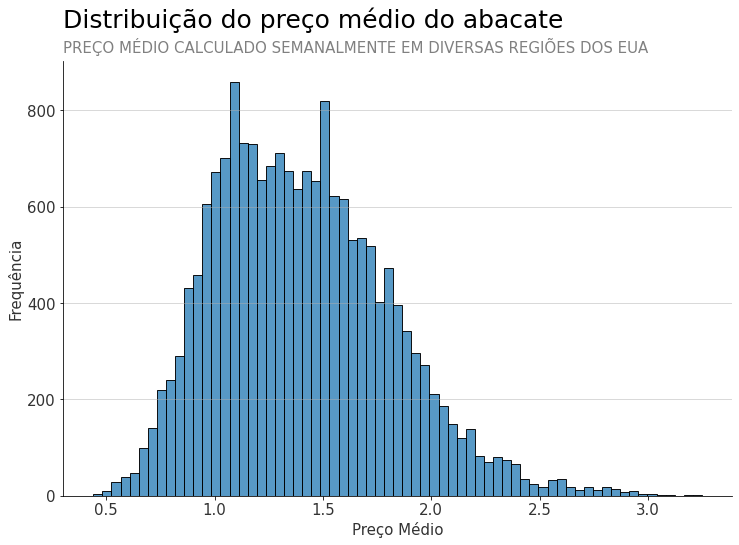

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(12, 8))

# Gerando o gráfico
sns.histplot(df['AveragePrice'])

# Plotando os títulos e rótulos
labs(ax, title='Distribuição do preço médio do abacate',
    subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')

# Mostrando o gráfico
plt.show()

A partir do histograma da variável resposta é possível notar que a mesma aparenta ter uma leve assimetria para direita, além disso aparenta ter dois picos, o que pode indicar que existem grupos dentro do dataset que se comportam de maneiras distintas. Para investigar tal hipótese temos que avaliar as variáveis categóricas a fim de identificar se existe um padrão diferente desta variável dependendo de alguma classe.

## Análise das variáveis categóricas

Antes de analisar o comportamento da variável resposta dependendo da classe, vou investigar a proporção de cada classe destas variáveis dentro do dataset, uma vez que o ideal é ter uma proporção balanceada destas classes para conseguirmos chegar uma conclusão mais robusta. Pensando nisso, vou analisar, em um gráfico de frequência, a quantidade de observações para cada tipo de abacate a fim de checar se existe algum desbalanceamento nessa variável.

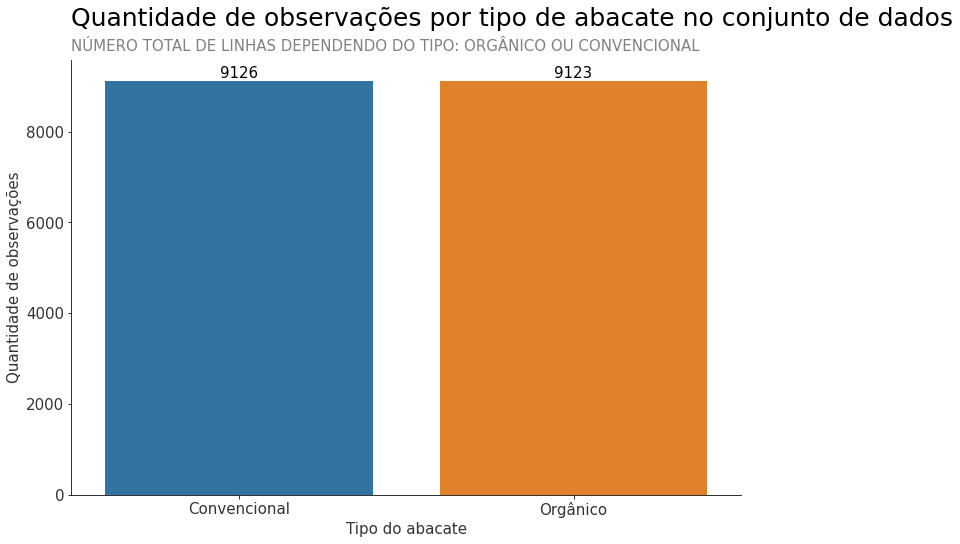

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(12,8))

# Gerando o gráfico
sns.countplot(df['type'], ax=ax)

# Plotando os títulos e rótulos
labs(ax, kwargs_grid={}, title='Quantidade de observações por tipo de abacate no conjunto de dados',
    subtitle='NÚMERO TOTAL DE LINHAS DEPENDENDO DO TIPO: ORGÂNICO OU CONVENCIONAL', xlabel='Tipo do abacate', ylabel='Quantidade de observações')

# Configurando o eixo x
plt.xticks(range(2), ['Convencional', 'Orgânico'])

# Anotando os valores acima das barras
annot_bar(ax, prop=False)

# Mostrando o gráfico
plt.show()

A partir do gráfico fica claro que, nesse dataset, não existe um desbalanceamento significante das classes correspondentes ao tipo de abacate, uma vez que a diferença é de apenas 3 observações dentro de um dataset com 18249 linhas. Com isso vou estudar como se comporta a distribuição da variável resposta para cada classe.

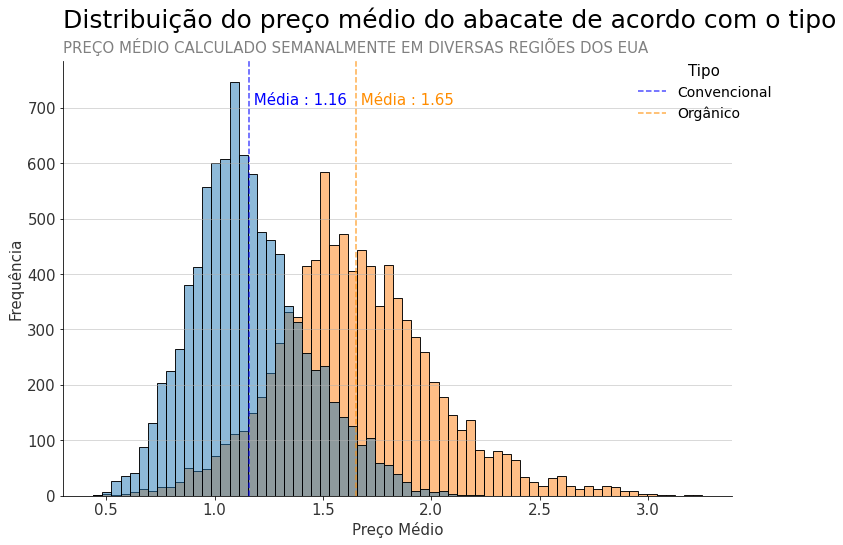

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(12, 8))

# Gerando o gráfico
sns.histplot(x='AveragePrice', hue='type', data=df)

# Plotando a média do preço para cada grupo
central_trend(df.query('type == "conventional"')['AveragePrice'], ax, color='blue', legend=' Média : ')
central_trend(df.query('type == "organic"')['AveragePrice'], ax, color='darkorange', legend=' Média : ')

# Plotando os títulos e rótulos
labs(ax, title='Distribuição do preço médio do abacate de acordo com o tipo',
    subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')

# Configurando a legenda
plt.legend(labels = ['Convencional', 'Orgânico'], title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])

# Mostrando o gráfico
plt.show()

A partir da distribuição do preço médio fica evidente que dependendo do tipo de abacate o comportamento da variável do preço se torna diferente, confirmando a hipótese de que existem mais de um grupo dentre as observações, onde a **média** do preço para **abacates convencionais é de 1,16** e para **abacates orgânicos é de 1,65**. <br>

Além disso, outra variável categórica presente é a variável correspondente a região, agora vou analisar esta variável para perceber se existe alguma diferença no comportamento em relação a região também. No entanto, esta variável possui mais classes e fica mais difícil a visualização, por esta razão, para checar o balanceamento vou utilizar a função `value_counts` que vai contar a quantidade de observações para cada região.

In [ ]:
df['region'].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

Como é possível notar o dataset possui as linhas muito bem divididas entre as regiões, onde apenda a região `WestTexNewMexico` não possui 338 linhas, porém possui 335, uma diferença não significativa dentro do geral.<br> 
Agora para analisar se existe uma influência destas regiões no preço médio decidi visualizar um boxplot de 10 regiões aleatórias, para ter uma ideia do comportamento do preço e ao mesmo tempo facilitar a visualização, e, além disso, separar os tipos convencional e orgânico.

In [ ]:
# Definindo a semente aletória a fim de gerar reprodutibilidade de resultados
np.random.seed(SEED)

# Selecionando 10 regiões aleatoriamente
random_regions = np.random.choice(df['region'].unique(), size=10)
random_regions

array(['SouthCarolina', 'Denver', 'Pittsburgh', 'RaleighGreensboro',
       'Seattle', 'Columbus', 'HartfordSpringfield', 'Portland',
       'BaltimoreWashington', 'BuffaloRochester'], dtype=object)

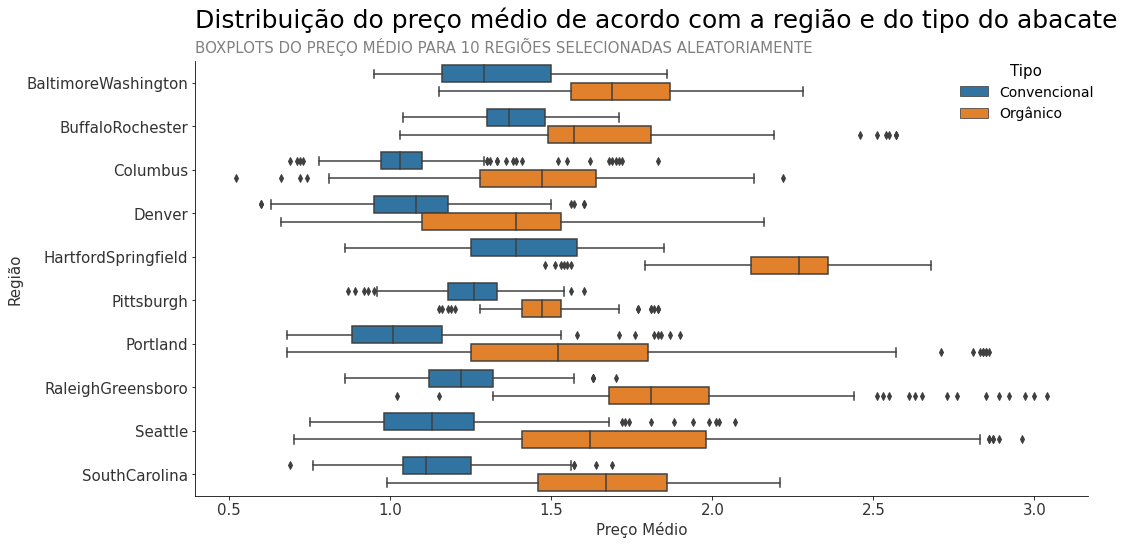

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(16, 8))

# Gerando a figura
sns.boxplot(y='region', x='AveragePrice', data=df.query('region in @random_regions'), hue='type', ax=ax)

# Plotando os títulos e rótulos
labs(ax, xlabel='Preço Médio', ylabel='Região', title='Distribuição do preço médio de acordo com a região e do tipo do abacate',
    subtitle='BOXPLOTS DO PREÇO MÉDIO PARA 10 REGIÕES SELECIONADAS ALEATORIAMENTE', kwargs_grid={})

# Configurando a legenda
ax.legend(title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])
ax.legend_.texts[0].set_text('Convencional')
ax.legend_.texts[1].set_text('Orgânico')

# Mostrando o gráfico
plt.show()

A partir do gráfico nota se que dependendo da região em questão, o preço varia em intervalos de valores muitos distintos e com diferentes variações, o que indica que a **região é um fator importante** na hora de se predizer o preço médio do abacate.

## Análise temporal

Além das variáveis categóricas, nesse dataset, existe uma variável correspondente a data da observação, e uma variável correspondente ao ano. Com isso é importante se analisar se existe alguma sazonalidade do preço médio e se da para extrair informações relevantes como o mês de cada observação.

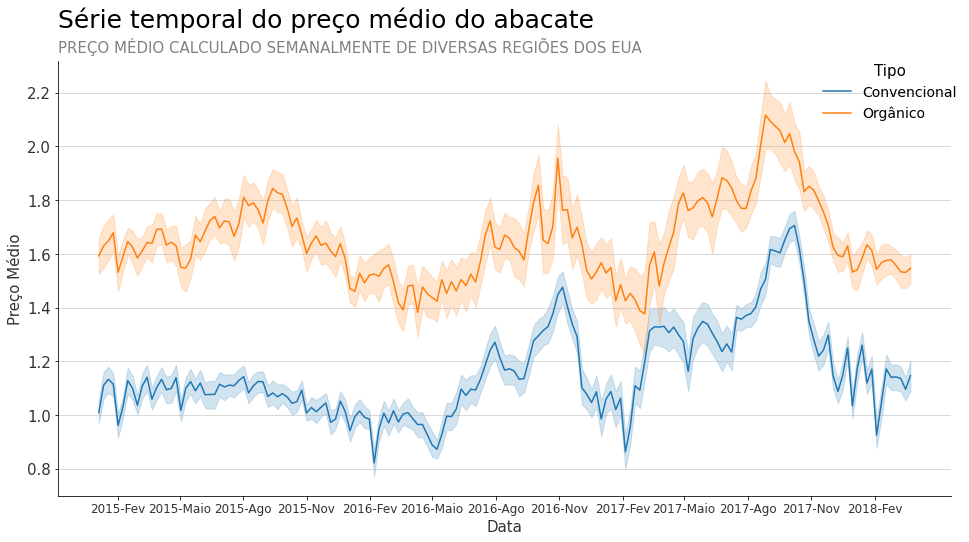

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(16,8))

# Gerando o gráfico
sns.lineplot(x='Date', y='AveragePrice', data=df, hue='type')

# Plotando os títulos e rótulos
labs(ax, title='Série temporal do preço médio do abacate', subtitle='PREÇO MÉDIO CALCULADO SEMANALMENTE DE DIVERSAS REGIÕES DOS EUA',
    xlabel='Data', ylabel='Preço Médio')

# Configurando o eixo x
plt.xticks(pd.date_range(min(df['Date']), max(df['Date']), freq='3MS'),
           pd.date_range(min(df['Date']), max(df['Date']), freq='3MS').strftime('%Y-%b').map(func_map_months), 
           color='#333333', fontsize=12)

# Configurando a legenda
plt.legend(labels = ['Convencional', 'Orgânico'], title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])

# Mostrando o gráfico
plt.show()

A partir do gráfico das séries temporais do preço médio de acordo com o tipo do abacate, já é possível perceber padrões, por exemplo, em todos os anos teve **uma queda no preço no mês de fevereiro** para ambos os tipos, além disso parece haver um **aumento desse preço entre agosto e outubro**, ou seja, utilizar essa **informação** de alguma forma pode ser **importante** para predizer esse preço médio. 

Para confirmar esta hipótese vou armazenar a informação do mês do ano e da semana do ano, uma vez que as observações são semanais, em um dataframe com a data, o ano, o preço médio e o tipo, para cada uma dessas informações extraídas da data.

In [ ]:
# Criando o dataframe com a data e o preço médio
df_time = df[['Date', 'AveragePrice', 'type', 'year']]

# Extraindo o mês da data
df_time['month'] = df_time['Date'].dt.month

# Extraindo a semana do ano da data
df_time['week_year'] = df_time['Date'].dt.week

# Exibindo as 5 primeiras linhas
df_time.head()

,Date,AveragePrice,type,year,month,week_year
0,2015-12-27,1.33,conventional,2015,12,52
1,2015-12-20,1.35,conventional,2015,12,51
2,2015-12-13,0.93,conventional,2015,12,50
3,2015-12-06,1.08,conventional,2015,12,49
4,2015-11-29,1.28,conventional,2015,11,48


In [ ]:
# Definindo as cores para cada ano dependendo do tipo do abacate
palette_conventional = ['#23B5DF', '#437AE1', '#1838EA', '#091E94']
palette_organic = ['#ECAC2D', '#D46010', '#E33A09', '#F90202']

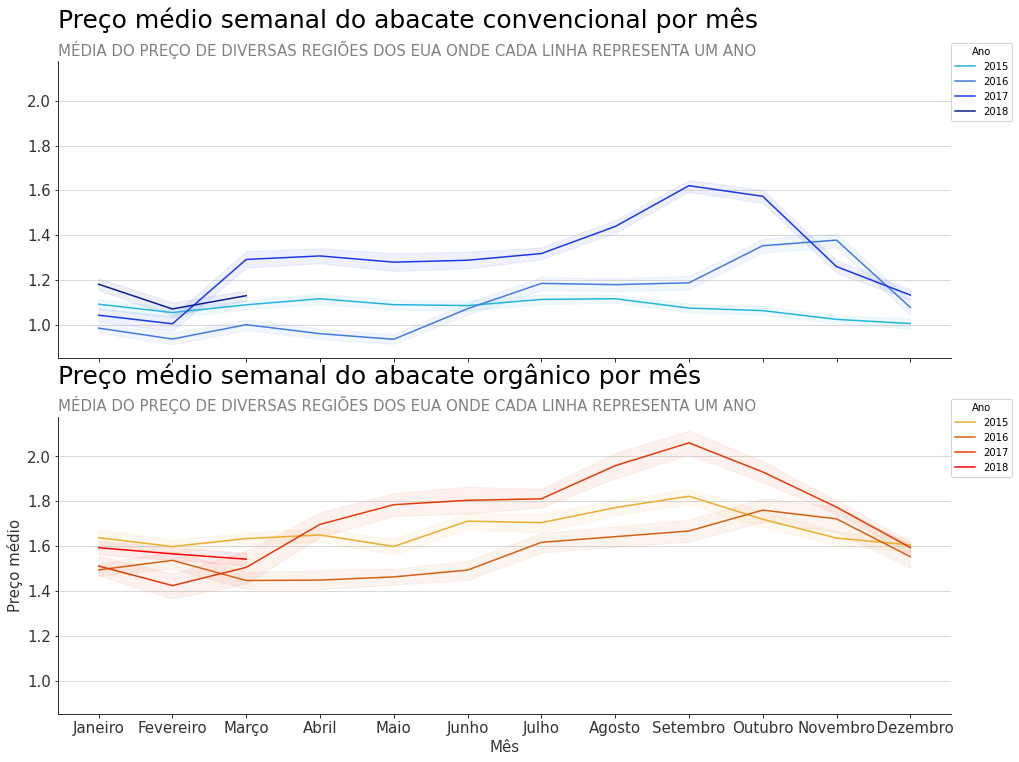

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(2, 1,figsize=(16, 12), sharex=True, sharey=True)

# Gerando o gráfico do tipo convencional
sns.lineplot(x='month', y='AveragePrice', data=df_time.query("type=='conventional'"), 
             hue='year', ax=ax[0], palette=palette_conventional, err_kws={'alpha':0.07})

# Gerando o gráfico do tipo orgânico
sns.lineplot(x='month', y='AveragePrice', data=df_time.query("type=='organic'"), 
             hue='year', ax=ax[1], palette=palette_organic, err_kws={'alpha':0.07})

# Configurando o eixo x
plt.xticks(range(1,13), ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', '  Dezembro'])

# Plotando os títulos e rótulos
labs(ax[0], title='Preço médio semanal do abacate convencional por mês', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')
labs(ax[1], title='Preço médio semanal do abacate orgânico por mês', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO',
    xlabel='Mês', ylabel='Preço médio')

# Configurando a legenda
ax[0].legend(title='Ano', loc=[1,0.8])
ax[1].legend(title='Ano', loc=[1,0.8])

# Mostrando o gráfico
plt.show()

A partir do gráfico fica evidente que, de fato, existe uma **sazonalidade anual** no preço médio do abacate, tanto do tipo convencional quanto do orgânico, onde no mês de **fevereiro** parece haver uma **queda** no preço e em **setembro/outubro** há um **aumento** do preço.

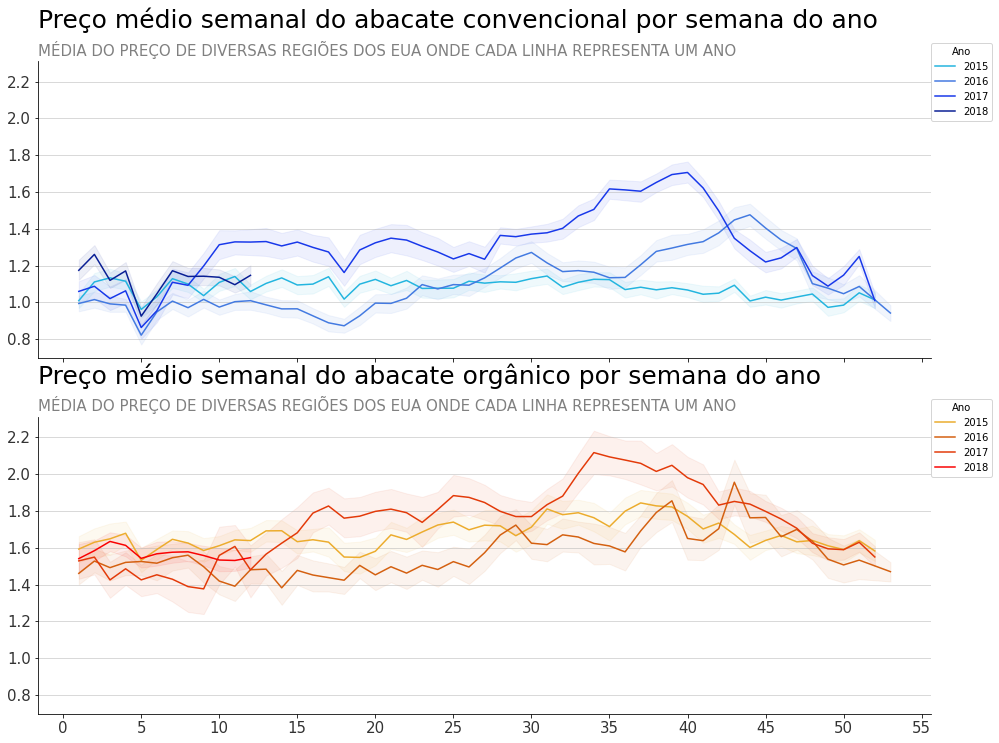

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(2, 1,figsize=(16, 12), sharex=True, sharey=True)

# Gerando o gráfico do tipo convencional
sns.lineplot(x='week_year', y='AveragePrice', data=df_time.query("type=='conventional'"), 
             hue='year', ax=ax[0], palette=palette_conventional, err_kws={'alpha':0.07})

# Gerando o gráfico do tipo orgânico
sns.lineplot(x='week_year', y='AveragePrice', data=df_time.query("type=='organic'"), 
             hue='year', ax=ax[1], palette=palette_organic, err_kws={'alpha':0.07})

# Configurando o eixo x
plt.xticks(range(0,58,5))

# Plotando os títulos e rótulos
labs(ax[0], title='Preço médio semanal do abacate convencional por semana do ano', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')
labs(ax[1], title='Preço médio semanal do abacate orgânico por semana do ano', subtitle='MÉDIA DO PREÇO DE DIVERSAS REGIÕES DOS EUA ONDE CADA LINHA REPRESENTA UM ANO')

# Configurando a legenda
ax[0].legend(title='Ano', loc=[1,0.8])
ax[1].legend(title='Ano', loc=[1,0.8])

# Mostrando o gráfico
plt.show()

Dessa vez olhando para cada semana do ano ao invés do mês fica ainda mais claro essa sazonalidade anual, onde, principalmente para o abacate convencional, existe uma **queda** do preço na **quinta semana do mês**, que ocorre no começo do mês de fevereiro. Este fato pode ser causado por variações no clima dependendo da época do ano, o que pode afetar a produção, e, consequentemente o preço.

## Análise das variáveis numéricas

Por fim, vou analisar as variáveis numéricas contidas no conjunto de dados, começando pela função `describe` para analisar as medidas descritivas dos dados.

In [ ]:
numeric_columns = df.select_dtypes('float64').columns.tolist()

In [ ]:
df[numeric_columns].describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000


A partir dos dados descritivos percebe-se a diferença nas grandezas destas variáveis, onde valores de volume total a maior média. Além disso, conclui-se que todas as variáveis tirando o volume total e o preço possuem o valor minímo igual a 0, onde a variável **'XLarge Bags'** possui o valor **minímo e a mediana igual a 0**, ou seja, **pelo menos 50% dos valores são iguais a zero** e mesmo assim a **média é 3106,43**, indicando que tal variável precisa ser investigada e entender o porquê dessa **diferença entre a média e a mediana**.

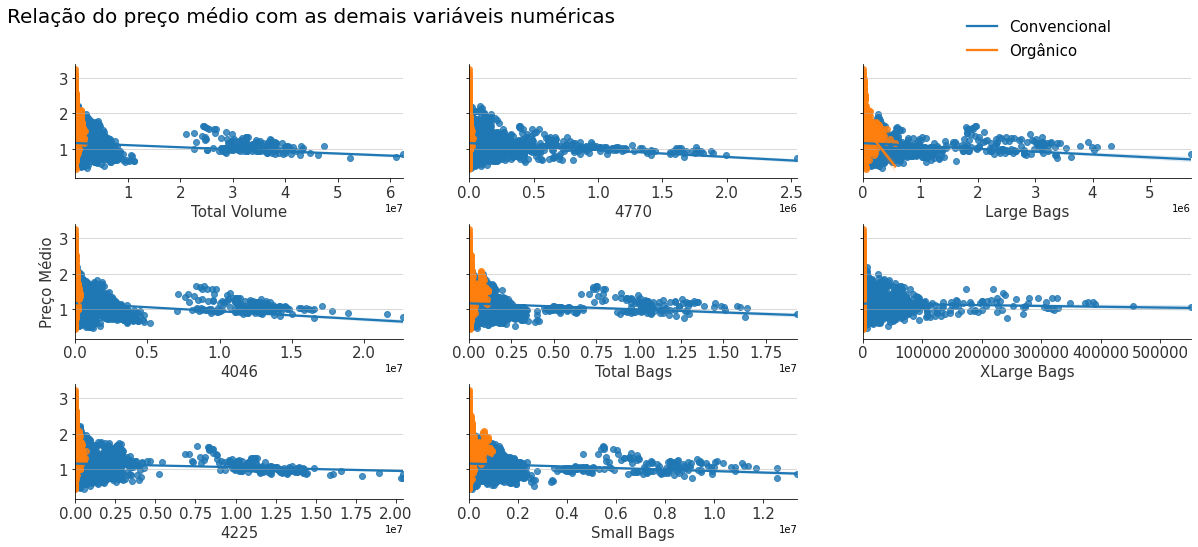

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(3, 3, figsize=(20,8), sharey=True)

# Configurando o espaço entre os subplots
plt.subplots_adjust(hspace=.4)

# Percorrendo as colunas numéricas sem o preço médio
for i, col in enumerate(df[numeric_columns].drop('AveragePrice', axis=1).columns):
    
    # Configurando linha e coluna atual a partir do número da iteração do for 
    if i < 3:
        j=0
    elif i < 6:
        j=1
        i=i-3
    else:
        j=2
        i=i-6
    # Plotando o gráfico com base no tipo do abacate
    hue_regplot(col, 'AveragePrice', hue='type', data=df, ax=ax[i,j])
    
    # Plotando os rótulo do eixo x
    labs(ax[i,j], xlabel=col)

# Plotando o título
fig.suptitle('Relação do preço médio com as demais variáveis numéricas', fontsize=20, horizontalalignment='right')

# Configurando a legenda
ax[0, 1].legend(labels=['Convencional', 'Orgânico'], fontsize=15, frameon=False, loc=[1.5,1])

# Configurando o rótulo do eixo y
ax[1, 0].set_ylabel('Preço Médio')

# Eliminando o eixo que não foi utilizado
plt.delaxes(ax[-1,-1])

A partir dos gráficos de cada variável numérica em relação a variável resposta do preço médio, onde cada cor representa um tipo de abacate, é possível perceber que há uma diferença muito grandes nesses valores de acordo com o tipo, onde os **valores para os abacates orgânicos são muito menores**, fato que pode explicar a diferença da média e da mediana da variável **'XLarge Bags'**. Por esta razão, acredito que analisar esses **dois grupos separadamente** é fundamental.

Além disso, pelo gráfico não ficou claro se existe uma relação linear entre as variáveis, mas aparenta que existe uma relação mas a mesma não é linear, para avaliar isso vou olhar para as correlações entre as variáveis.

In [ ]:
# Separando dois datafames para cada tipo de abacate para analisar separadamente
df_conventional = df.query('type == "conventional"')
df_organic = df.query('type == "organic"')

In [ ]:
# Calculando as correlações de peason e spearman para os abacates convencionais
cor_pearson_conv = df_conventional[numeric_columns].corr()
cor_spearman_conv = df_conventional[numeric_columns].corr(method='spearman')

# Calculando as correlações de peason e spearman para os abacates orgânicos
cor_pearson_org = df_organic[numeric_columns].corr()
cor_spearman_org = df_organic[numeric_columns].corr(method='spearman')

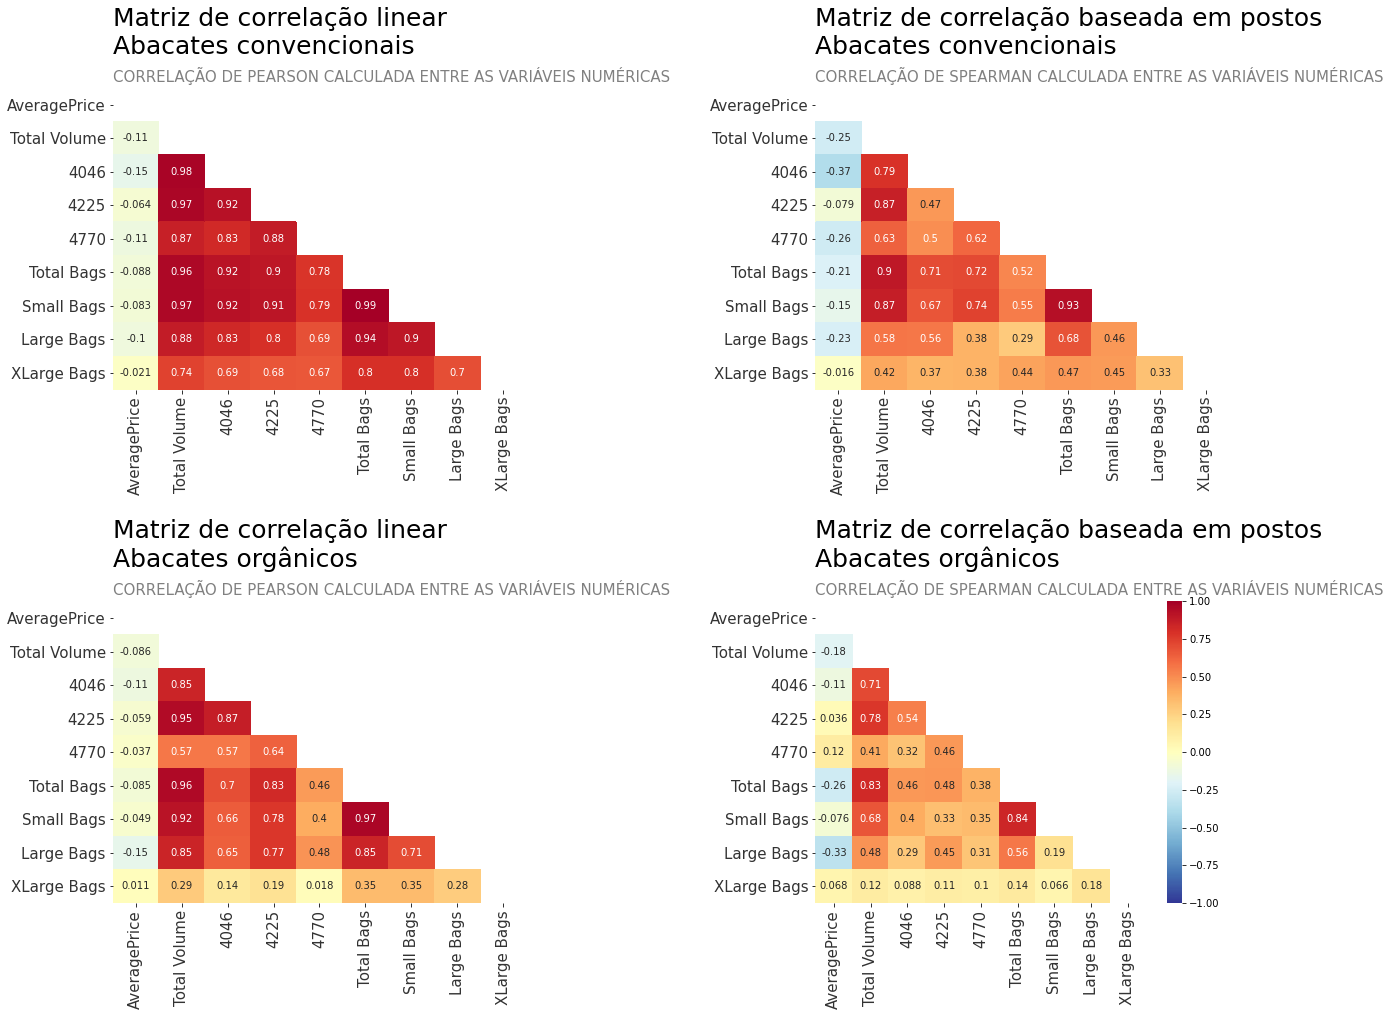

In [ ]:
# Gerando a figura
fig,ax = plt.subplots(2, 2,figsize=(20,15))

# Configurando o espaço entre os subplots
plt.subplots_adjust(hspace=.7, wspace=0.7)

# Configurando uma máscara para ocultar a matriz diagonal e triangular superior
mask = np.triu(np.ones_like(cor_pearson_conv, dtype=bool))
# Gerando o gráfico da correlação de pearson dos abacates convencionais
sns.heatmap(cor_pearson_conv, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[0, 0], cbar=False)
# Plotando os títulos e rótulos
labs(ax[0, 0], kwargs_grid={}, title='Matriz de correlação linear \nAbacates convencionais', subtitle='CORRELAÇÃO DE PEARSON CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')

# Configurando uma máscara para ocultar a matriz diagonal e triangular superior
mask = np.triu(np.ones_like(cor_spearman_conv, dtype=bool))
# Gerando o gráfico da correlação de spearman dos abacates convencionais
sns.heatmap(cor_spearman_conv, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[0, 1], cbar=False)
# Plotando os títulos e rótulos
labs(ax[0, 1], kwargs_grid={}, title='Matriz de correlação baseada em postos \nAbacates convencionais', subtitle='CORRELAÇÃO DE SPEARMAN CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')

# Configurando uma máscara para ocultar a matriz diagonal e triangular superior
mask = np.triu(np.ones_like(cor_pearson_org, dtype=bool))
# Gerando o gráfico da correlação de pearson dos abacates orgânicos
sns.heatmap(cor_pearson_org, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[1, 0], cbar=False)
# Plotando os títulos e rótulos
labs(ax[1, 0], kwargs_grid={}, title='Matriz de correlação linear \nAbacates orgânicos', subtitle='CORRELAÇÃO DE PEARSON CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')

# Configurando uma máscara para ocultar a matriz diagonal e triangular superior
mask = np.triu(np.ones_like(cor_spearman_org, dtype=bool))
# Gerando o gráfico da correlação de spearman dos abacates orgânicos
sns.heatmap(cor_spearman_org, mask=mask, annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1, ax=ax[1, 1])
# Plotando os títulos e rótulos
labs(ax[1, 1], kwargs_grid={}, title='Matriz de correlação baseada em postos \nAbacates orgânicos', subtitle='CORRELAÇÃO DE SPEARMAN CALCULADA ENTRE AS VARIÁVEIS NUMÉRICAS')

# Mostrando o gráfico
plt.show()

A partir das matrizes de correlações é possível perceber que nenhuma das variáveis numéricas possui uma alta correlação com a variável resposta do preço médio para ambos os tipos do abacate, no entanto, ao olhar para correlação baseada em postos parece que existe um pequeno aumento nessa correlação, fato que **pode indicar que existe relação não linear entre as variáveis**. 

Além disso, fica claro que as demais variáveis possuem uma alta correlação linear entre elas, principalmente o volume total. Portanto, vou **analisar separadamente esta variável de volume tota**l a fim de identificar relações com o preço mais facilmente e depois avaliar se elas fazem sentidos para as demais variáveis.

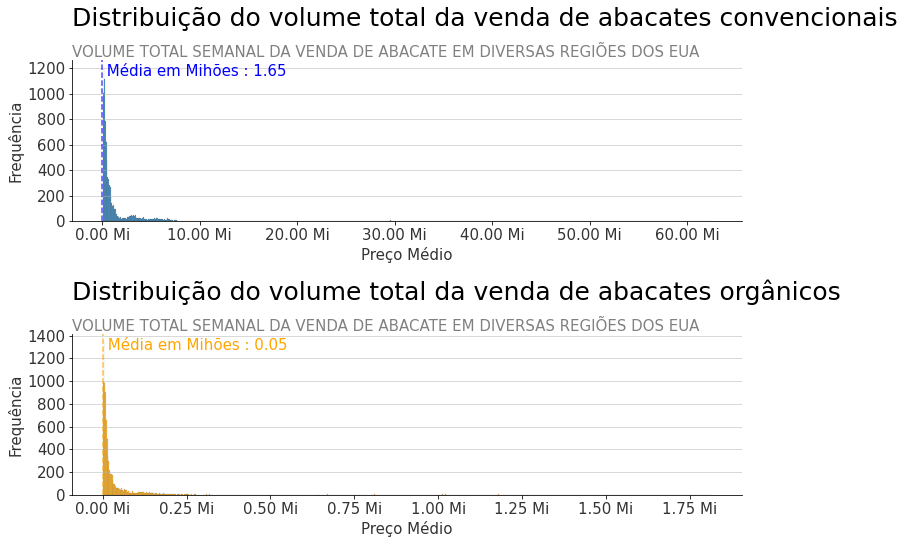

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(2,1,figsize=(12, 8))

# Configurando o espaço entre os subplots
plt.subplots_adjust(hspace=.7)

# Gerando o histograma do volume total dos abacates convencionais
sns.histplot(x='Total Volume', data=df_conventional, ax=ax[0])

# Plotando os títulos e rótulos
labs(ax[0], title='Distribuição do volume total da venda de abacates convencionais',
    subtitle='VOLUME TOTAL SEMANAL DA VENDA DE ABACATE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')

# Plotando a média do volume total dos abacates convencionais 
central_trend(df_conventional['Total Volume']/1E6, ax[0], color='blue', legend=' Média em Mihões : ')

# Gerando o histograma do volume total dos abacates orgânicos
sns.histplot(x='Total Volume', data=df_organic,ax=ax[1], color='orange')

# Plotando a média do volume total dos abacates orgânicos 
central_trend(df_organic['Total Volume']/1E6, ax[1], color='orange', legend=' Média em Mihões : ')

# Plotando os títulos e rótulos
labs(ax[1], title='Distribuição do volume total da venda de abacates orgânicos',
    subtitle='VOLUME TOTAL SEMANAL DA VENDA DE ABACATE EM DIVERSAS REGIÕES DOS EUA', xlabel='Preço Médio', ylabel='Frequência')

# Configurando a grandeza do eixo x
ax[0].xaxis.set_major_formatter(million_formatter)
ax[1].xaxis.set_major_formatter(million_formatter)

# Mostrando o gráfico
plt.show()

Observando os histogramas do volume total por cada tipo de abacate, nota se que para ambos os tipos existem observações muito distantes das médias, o que poderia indicar "outliers", no entanto como foi visto no começo desse notebook cada observação está relacionada a uma região, ou seja, pode haver uma relação entre os altos valores e a região, onde esses **valores maiores podem corresponder a regiões com uma maior população** que consequentemente vão possuir **um volume total de venda maior**. <br>

Pensando nisso vou padronizar a variável de volume para cada tipo de abacate separadamente e avaliar as observações que estão a 3 ou mais desvios padrões da média, ou seja, que poderiam ser classificadas como "outliers". Essa padronização será realizada pela função `stats.zscore`.

In [ ]:
# Calculando os valores padronizados para a coluna volume total dos abacates convencionais
z_total_volume_conv = stats.zscore(df_conventional['Total Volume'], ddof=1) 
# Filtrando as observações com esses valores padronizados maiores que 3
df_total_volume_outlier_conv = df_conventional[z_total_volume_conv >= 3]

# Calculando os valores padronizados para a coluna volume total dos abacates orgânicos
z_total_volume_org = stats.zscore(df_organic['Total Volume'], ddof=1) 
# Filtrando as observações com esses valores padronizados maiores que 3
df_total_volume_outlier_org = df_organic[z_total_volume_org >= 3]

In [ ]:
# Observando as 5 primeiras linhas
df_total_volume_outlier_conv.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
2652,2015-12-27,0.95,27297983.67,9626901.09,10197890.05,1184340.09,6288852.44,4850404.09,1252626.31,185822.04,conventional,2015,TotalUS
2653,2015-12-20,0.98,25083647.17,8710021.76,9329861.85,1201020.01,5842743.55,4618389.66,1025048.77,199305.12,conventional,2015,TotalUS
2654,2015-12-13,0.93,28041335.38,9855053.66,10805838.91,1016163.17,6364279.64,4964462.13,1371440.28,28377.23,conventional,2015,TotalUS
2655,2015-12-06,0.89,28800396.57,9405464.36,12160838.62,931830.63,6302262.96,5005077.36,1233956.21,63229.39,conventional,2015,TotalUS
2656,2015-11-29,0.99,22617999.38,8094803.56,9003178.41,731008.41,4789009.00,3901953.04,856560.34,30495.62,conventional,2015,TotalUS


In [ ]:
# Observando as 5 primeiras linhas
df_total_volume_outlier_org.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11778,2015-12-27,1.52,549787.59,89709.92,206198.62,5836.04,248043.01,142262.93,105780.08,0.0,organic,2015,TotalUS
11779,2015-12-20,1.53,531478.24,93849.30,205909.13,8733.11,222986.70,130418.73,92567.97,0.0,organic,2015,TotalUS
11780,2015-12-13,1.43,624300.31,91837.92,222314.60,11645.54,298502.25,149767.80,148734.45,0.0,organic,2015,TotalUS
11781,2015-12-06,1.52,514112.96,90203.21,212582.74,4066.09,207260.92,108684.49,98576.43,0.0,organic,2015,TotalUS
11782,2015-11-29,1.50,507830.81,79215.51,208733.32,3749.48,216132.50,91658.24,124474.26,0.0,organic,2015,TotalUS


Agora com essas observações separadas vou avaliar a coluna de região e verificar **quais regiões apresentam esses valores mais distantes da média**.

In [ ]:
df_total_volume_outlier_conv['region'].unique()

array(['TotalUS'], dtype=object)

In [ ]:
df_total_volume_outlier_org['region'].unique()

array(['TotalUS', 'West', 'Northeast', 'NewYork'], dtype=object)

Observando os valores únicos para ambos os tipos de abacate nota se que apenas 1 região está presente nos dados com 3 desvios padrões da média para os abacates convencionais, e 5 para os abacates orgânicos, essas regiões por sua vez compreendem os **Estados Unidos inteiro (`TotalUS`)** em ambos os casos, e os demais que aparecem  no caso dos abacates orgânicos são as regiões **Oeste (`West`), Nordeste (`Northeast`), e Nova York (`NewYork`)**, ou seja, pelo fato de termos uma região que soma os valores de todas as regiões dos Estados Unidos, e regiões com todo o Oeste  e Nordeste do país, além de Nova York, o quarto estado mais populoso dos Estados Unidos, fica claro que na verdade esses valores **não são "outliers"**, eles estão distantes da média pois **correspondem a estados e regiões com maior população**, ou seja, além de levar em consideração o tipo do abacate a **região é um fator fundamental**. Por isso, vou analisar qual essa relação do volume e do preço para verificar se existe uma relação clara ou se é necessária alguma transformação dessas variáveis afim de padronizá-las de acordo com o estado em questão. 

In [ ]:
# Calculando a média do volume e preço por tipo e região
df_volume_price_mean_region_type = df.groupby(['region', 'type']).agg({'Total Volume':'mean', 'AveragePrice':'mean'}).sort_values('Total Volume').reset_index()
# Definindo os nomes das colunas
df_volume_price_mean_region_type.columns = ['region', 'type', 'Volume_total_mean', 'AveragePrice_mean']
df_volume_price_mean_region_type.head()

,region,type,Volume_total_mean,AveragePrice_mean
0,Albany,organic,2172.713018,1.773314
1,Boise,organic,2441.699704,1.620237
2,Syracuse,organic,2666.716213,1.653728
3,Louisville,organic,2912.291006,1.468047
4,Jacksonville,organic,3100.421243,1.828284


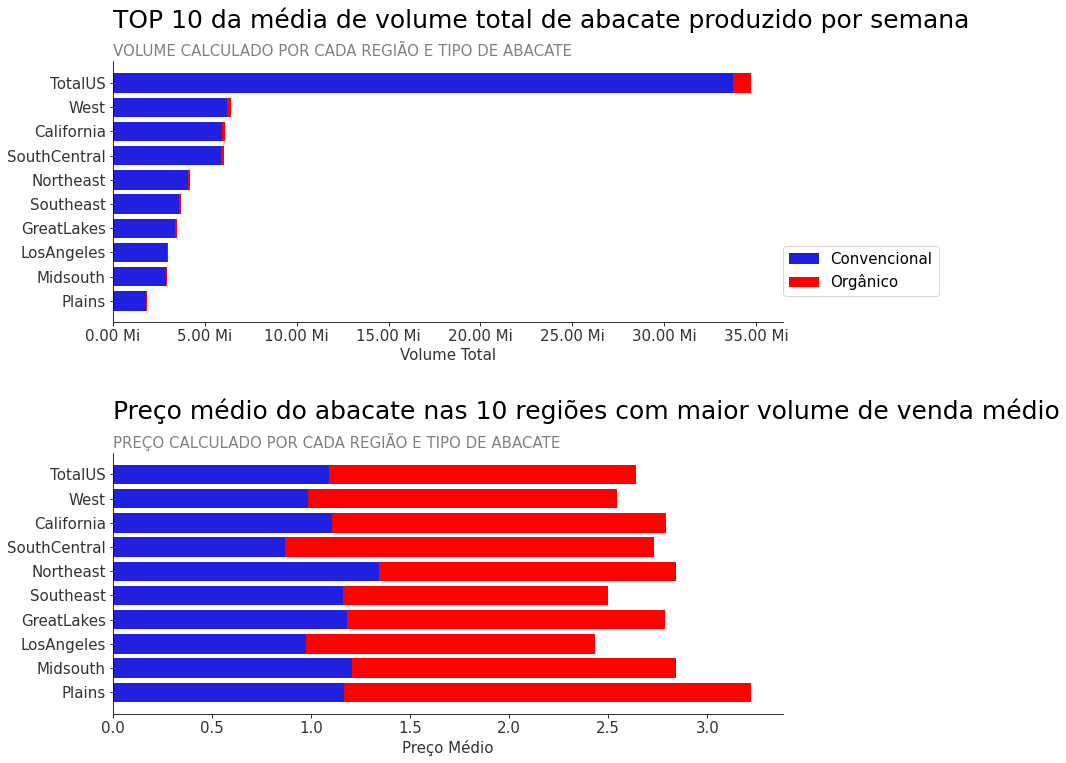

In [ ]:
# Gerando a figura
fig, ax= plt.subplots(2, 1, figsize=(12,12))

# Configurando o espaço entre os subplots
plt.subplots_adjust(hspace=.5)

# Gerando um gráfico de barras horizontais para cada tipo de abacate do volume total médio das top 10 regiões
sns.barplot(y='region', x='Volume_total_mean', data = df_volume_price_mean_region_type.query('type=="conventional"').iloc[-10:,:], 
            color='blue', ax=ax[0], label = 'Convencional')
ax[0].barh(y='region', width='Volume_total_mean', data = df_volume_price_mean_region_type.query('type=="organic"').iloc[-10:,:], 
           color='red', left=[rect.get_width() for rect in ax[0].patches],  label = 'Orgânico')

# Definindo a grandeza do eixo x do volume
ax[0].xaxis.set_major_formatter(million_formatter)

# Plotando os títulos e rótulos
labs(ax[0], kwargs_grid={}, title='TOP 10 da média de volume total de abacate produzido por semana',
     subtitle='VOLUME CALCULADO POR CADA REGIÃO E TIPO DE ABACATE', xlabel='Volume Total')


# Gerando um gráfico de barras horizontais para cada tipo de abacate do preço médio das top 10 regiões com maior volume
sns.barplot(y='region', x='AveragePrice_mean', data = df_volume_price_mean_region_type.query('type=="conventional"').iloc[-10:,:], 
            color='blue', ax=ax[1], label = 'Convencional')
ax[1].barh(y='region', width='AveragePrice_mean', data = df_volume_price_mean_region_type.query('type=="organic"').iloc[-10:,:], 
           color='red', left=[rect.get_width() for rect in ax[1].patches],  label = 'Orgânico')

# Plotando os títulos e rótulos
labs(ax[1], kwargs_grid={}, title='Preço médio do abacate nas 10 regiões com maior volume de venda médio', 
     subtitle='PREÇO CALCULADO POR CADA REGIÃO E TIPO DE ABACATE', xlabel='Preço Médio')

# Invertendo a ordem das barras
ax[0].invert_yaxis()
ax[1].invert_yaxis()

# Configurando a legenda
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels, fontsize=15, loc=[1,0.1])

# Mostrando o gráfico
plt.show()

Comparando os gráficos de volume total e de preço médio das 10 regiões mais vendedoras de abacate, **não é possível identificar uma relação clara onde o volume total influência no preço**, ou seja, de uma maneira geral essas duas variáveis não tem uma relação tão óbvia. No entanto, como foi visto o tipo e região de cada observação influenciam nos valores dos dados, por esta razão acredito que, como temos um balanceamento das classes de ambas as variáveis, podemos agrupar as observações pela região e pelo tipo e com isso analisar se existe essa relação entre o preço médio e o volume.


Pensando nisto, resolvi **padronizar o volume total com base na média e no desvio padrão de cada combinação tipo e região**, com isso o objetivo é analisar se aquele **determinado tipo observado na determinada região aumentou em relação ao conjunto de dados do tipo e da região em questão**. 

Para isso vou utilizar a classe desenvolvida e definida no começo deste notebook `ScalerGroup` que irá agrupar o dataframe de acordo com os grupos de variáveis categóricas calculando a média e o desvio padrão e com isso padronizar uma variável numérica levando em consideração o grupo de cada observação.

In [ ]:
sg = ScalerGroup(groups=['type', 'region'], cols_scaler=['Total Volume'])
df_scaled_volume_group = sg.fit_transform(df)
df_scaled_volume_group.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,-0.987456,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,-1.309863,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,0.872088,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,-0.479180,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,-1.442047,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Agora com os dados de volume total padronizados pelo tipo e região, vou analisar o histograma para ver como essa variável está distribuída.

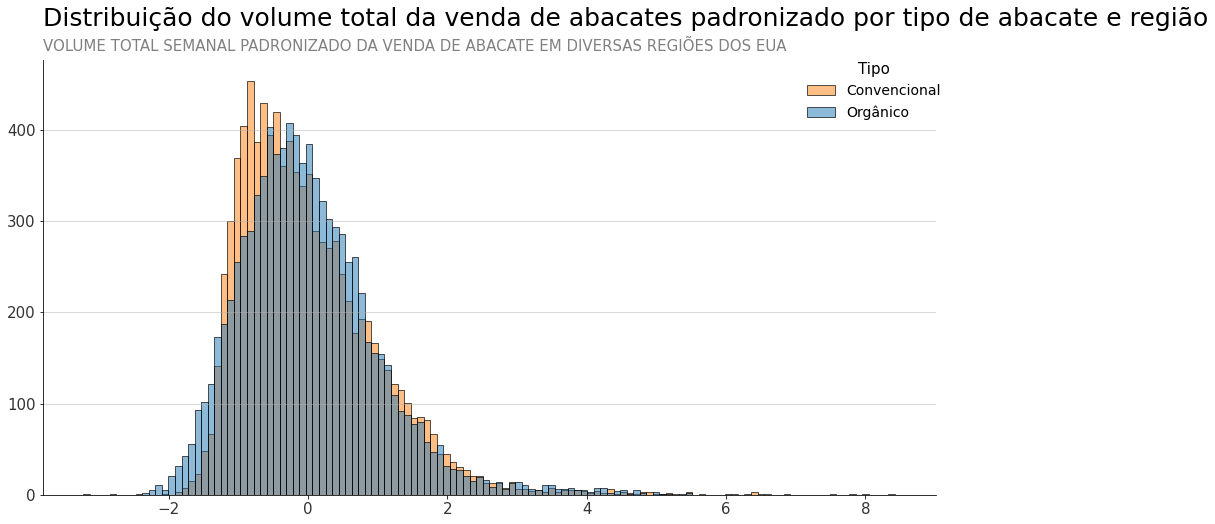

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize=(16, 8))

# Gerando o histograma
sns.histplot(x='Total Volume', data=df_scaled_volume_group, hue='type')

# Plotando os títulos e rótulos
labs(ax, title='Distribuição do volume total da venda de abacates padronizado por tipo de abacate e região',
     subtitle='VOLUME TOTAL SEMANAL PADRONIZADO DA VENDA DE ABACATE EM DIVERSAS REGIÕES DOS EUA')

# Configurando a legenda
plt.legend(labels = ['Convencional', 'Orgânico'], title='Tipo', fontsize=14, title_fontsize=15, frameon=False, loc=[.85,.85])

# Mostrando o gráfico
plt.show()

A partir do histograma parece que relamente o efeito da região e do tipo do abacate nos valores de volume total padronizados foram reduzidos, uma vez que parece haver uma **distribuição menos assimétrica** como existia anteriormente, para checar isso vou analisar, novamente, os valores que estão **a mais de 3 desvios padrões da média**, e como os dados foram padronizados, a **média vale zero** e o **desvio padrão vale 1**, ou seja os valores maiores ou iguais a 3, com isso analisar quais as regiões encontradas nesses valores para ver se realmente o efeito do tamanho das regiões e do tipo conseguiu ser reduzido.

In [ ]:
df_scaled_volume_group[df_scaled_volume_group['Total Volume'] >= 3]['region'].unique()

array(['Pittsburgh', 'Sacramento', 'Boston', 'California', 'Denver',
       'HarrisburgScranton', 'HartfordSpringfield', 'Jacksonville',
       'LosAngeles', 'MiamiFtLauderdale', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'Orlando', 'Philadelphia', 'RichmondNorfolk',
       'SanDiego', 'SanFrancisco', 'Southeast', 'Spokane', 'StLouis',
       'Tampa', 'TotalUS', 'Albany', 'Atlanta', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'Detroit', 'GrandRapids',
       'GreatLakes', 'Houston', 'Indianapolis', 'LasVegas', 'Midsouth',
       'Nashville', 'PhoenixTucson', 'Plains', 'Portland',
       'RaleighGreensboro', 'Seattle', 'SouthCarolina', 'SouthCentral',
       'West', 'WestTexNewMexico', 'BaltimoreWashington', 'DallasFtWorth',
       'Louisville', 'NorthernNewEngland', 'Roanoke', 'Syracuse', 'Boise',
       'BuffaloRochester'], dtype=object)

Agora é possível verificar que esses valores que ainda estão causando a assimetria à direita pertecem a **diversas regiões diferentes**.

In [ ]:
df_scaled_volume_group[df_scaled_volume_group['Total Volume'] >= 3]['type'].unique()

array(['conventional', 'organic'], dtype=object)

Além disso, é possível ver que dentre esses valores existem observações **tanto do tipo convencional quanto do tipo orgânico**.

Agora vou analisar como essa variável do volume total padronizada se comporta em **relação ao preço médio** e verificar se faz sentido padronizar os dados na hora de se treinar um modelo de machine learning com o objetivo de predizer o preço médio.

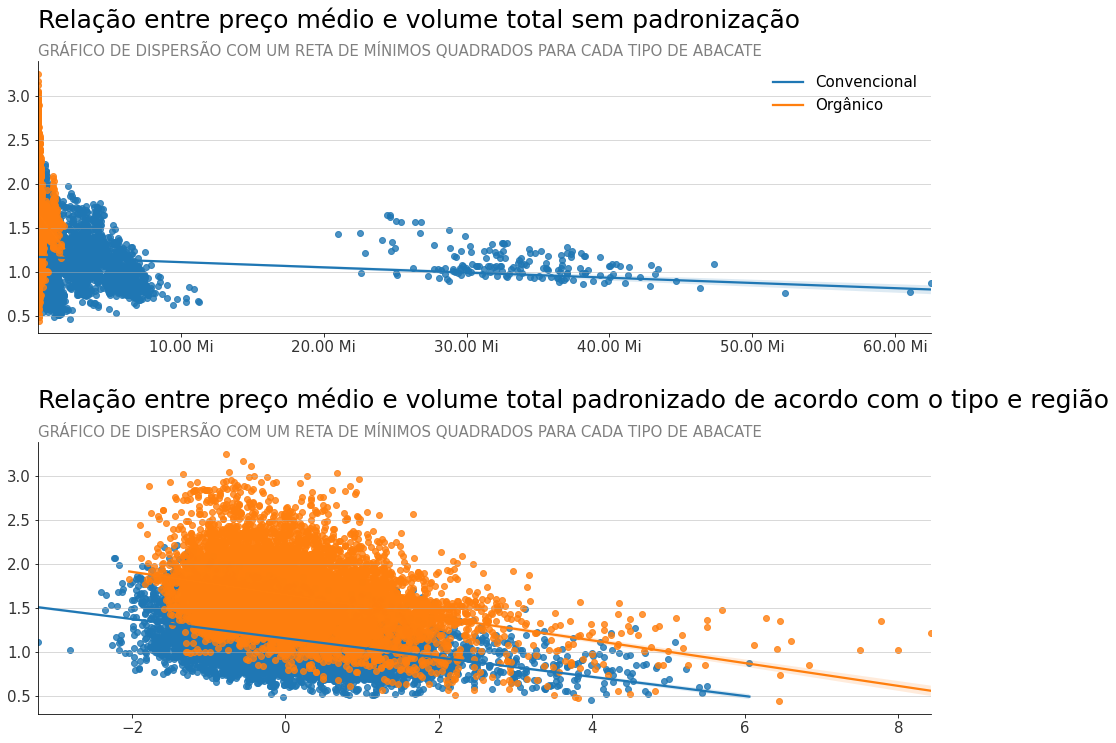

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=.4)
hue_regplot(x='Total Volume', y='AveragePrice', data=df, ax=ax[0], hue='type')
hue_regplot(x='Total Volume', y='AveragePrice', data=df_scaled_volume_group, ax=ax[1], hue='type')
labs(ax[0], title='Relação entre preço médio e volume total sem padronização', 
     subtitle='GRÁFICO DE DISPERSÃO COM UM RETA DE MÍNIMOS QUADRADOS PARA CADA TIPO DE ABACATE')
labs(ax[1], title='Relação entre preço médio e volume total padronizado de acordo com o tipo e região',
    subtitle='GRÁFICO DE DISPERSÃO COM UM RETA DE MÍNIMOS QUADRADOS PARA CADA TIPO DE ABACATE')
ax[0].legend(labels=['Convencional', 'Orgânico'], fontsize=15, frameon=False)
ax[0].xaxis.set_major_formatter(million_formatter)
plt.show()

Com base nos gráficos parece que a padronização surtiu efeito e agora a relação entre o preço e o volume olhando dentro do contexto do estado e do tipo parece ser mais clara onde nas semanas quando a **venda é maior o preço tende a ser mais baixo**, e, por outro lado em semanas quando o **volume das vendas é menor o preço costuma aumentar**.

Agora vou aplicar os mesmos passos para as demais variáveis numéricas e realizar uma análise para ver se pode ser uma boa idéia implementar uma padronização ao treinar um modelo. 

In [ ]:
sg = ScalerGroup(groups=['type', 'region'], cols_scaler=['Total Volume', '4046', '4225','4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'])
df_scaled_group = sg.fit_transform(df)
df_scaled_group.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,-0.987456,-0.556151,-0.777528,-0.311312,-0.894325,-0.492950,-0.599732,-0.447487,conventional,2015,Albany
1,2015-12-20,1.35,-1.309863,-0.636439,-1.148503,-0.299903,-0.757986,-0.353050,-0.598583,-0.447487,conventional,2015,Albany
2,2015-12-13,0.93,0.872088,-0.609765,1.289537,-0.218941,-0.987307,-0.590583,-0.597052,-0.447487,conventional,2015,Albany
3,2015-12-06,1.08,-0.479180,-0.535050,-0.115341,-0.283917,-1.380834,-1.001841,-0.588755,-0.447487,conventional,2015,Albany
4,2015-11-29,1.28,-1.442047,-0.577252,-1.178753,-0.280327,-1.317984,-0.948128,-0.571431,-0.447487,conventional,2015,Albany


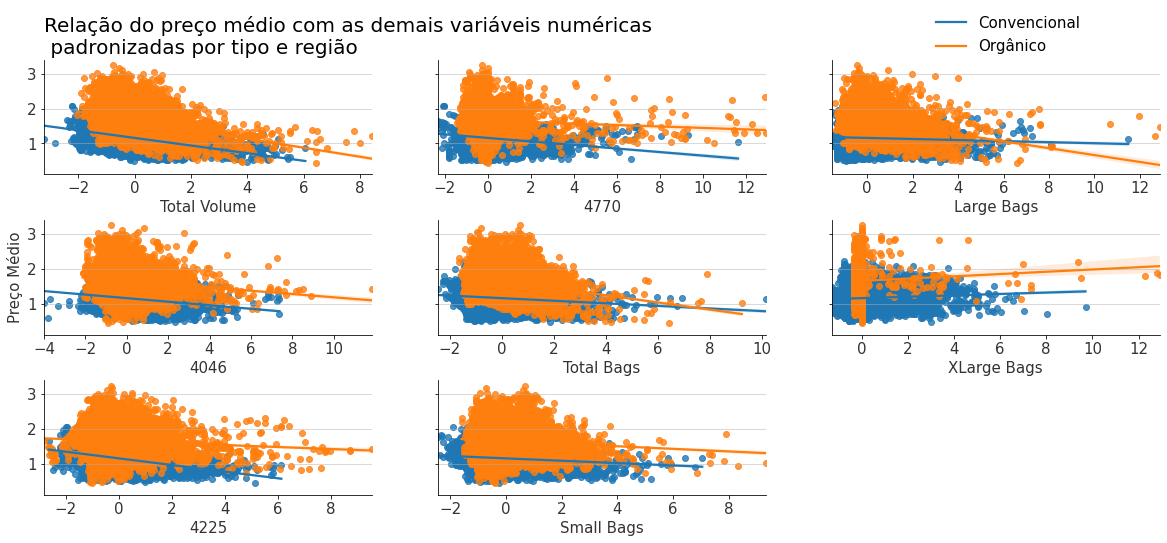

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(3, 3, figsize=(20,8), sharey=True)

# Configurando o espaço entre os subplots
plt.subplots_adjust(hspace=.4)

# Percorrendo as colunas numéricas sem o preço médio
for i, col in enumerate(df_scaled_group[numeric_columns].drop('AveragePrice', axis=1).columns):
    
    # Configurando linha e coluna atual a partir do número da iteração do for 
    if i < 3:
        j=0
    elif i < 6:
        j=1
        i=i-3
    else:
        j=2
        i=i-6
    # Plotando o gráfico com base no tipo do abacate
    hue_regplot(col, 'AveragePrice', hue='type', data=df_scaled_group, ax=ax[i,j])
    
    # Plotando os rótulo do eixo x
    labs(ax[i,j], xlabel=col)

# Plotando o título
plt.sca(ax[0,0])
plt.title('Relação do preço médio com as demais variáveis numéricas\n padronizadas por tipo e região', fontsize=20, loc='left')

# Configurando a legenda
ax[0, 1].legend(labels=['Convencional', 'Orgânico'], fontsize=15, frameon=False, loc=[1.5,1])

# Configurando o rótulo do eixo y
ax[1, 0].set_ylabel('Preço Médio')

# Eliminando o eixo que não foi utilizado
plt.delaxes(ax[-1,-1])

Agora observando os dados normalizados para cada grupo parece que, em comparação com os dados originais, a relação com a variável resposta **parece ser mais clara**, mesmo que ainda não exista uma relação tão forte para nenhumas delas. Por esta razão pode será analisado modelos com esse padronização e sem a mesma para ver se faz sentido realizar esse processo.

# Modelos Preditivos

## Métricas

Uma vez que a proposta do notebook é a predição do preço a fim de resolver um problema, métricas devem ser escolhidas e pré definidas afim de se testar os modelos e avaliar qual o melhor no contexto do problema a ser resolvida. Pensando nisso as seguintes métricas serão utilizadas para decidir qual modelo utilizar: 

* RMSE(raiz do erro quadrático médio) - Métrica que será a principal na determinação do melhor modelo. Tem o objetivo de resumir qual o erro do modelo, portanto quanto menor ela for melhor é a performance do modelo. Além disso, vou utilizá-la por ter a mesma unidade da variável medida, no caso o preço médio, e por fim ela dá um peso maior quanto maior o erro, sendo assim uma métrica mais sensível.<br>

* R2(coeficiente de determinação) - Métrica que será secundária e tem o objetivo de medir o quão bem o modelo está ajustado aos dados reais. Ela varia entre 0 e 1 onde quanto mais perto de 1 melhor o modelo está ajustado aos dados reais. Consegue dar uma ideia do quão bem está o modelo uma vez que não depende das unidades envolvidas.

## Validação cruzada

A fim de se construir um **resultado robusto** e tentar minimizar o efeito da aleatoriedade na hora de testar os modelos será realizada uma **validação cruzada** da seguinte forma : 

* Os dados serão **ordenados pela data**
* Os dados serão **embaralhados aleatoriamente**
* Os dados serão **divididos em 5 grupos aleatoriamente**

A partir dessa divisão serão realizados treinamentos e testes dos modelos preditivos a fim de se construir uma métrica para o modelo em questão que consiga generalizar ao máximo a performance para todos os dados, independente da época.

Para isso, primeiramente os dados serão separados no conjunto de dados das variáveis dependentes e a variável resposta(preço médio). Após isso, será utilizada a classe `sklearn.model_selection.KFold` que estabelecerá o objeto de validação cruzada utilizado em todos os modelos.

**OBS: O dataset utilizado para separar os dados entre X e y é o mesmo dataset original carregado sem nenhuma alteração**

In [ ]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [ ]:
df.shape

(18249, 13)

In [ ]:
# Armazenando os valores da coluna AveragePrice na variável y ordenando a pela data
y = df.sort_values('Date')['AveragePrice']
# Armazenando os valores das outras colunas restantes na variável X ordenando pela data
X = df.sort_values('Date').drop(['AveragePrice'], axis = 1)
# Definindo o objeto que dividirá o dataset de forma aleatória em 5 ao realizar a validação cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

Para ver como a validação cruzada será realizada em relação a data vou gerar um gráfico para visualizar isso de forma mais facilmente.

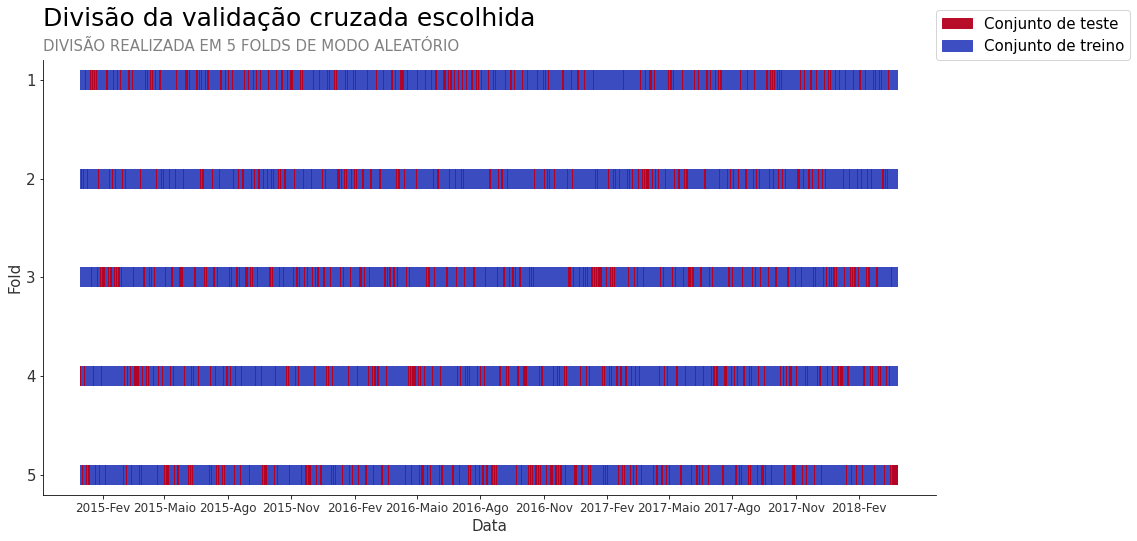

In [ ]:
# Gerando a figura
fig, ax = plt.subplots(figsize = (16, 8))

# Gerando o objeto com as cores
cmap_cv = plt.cm.coolwarm

# Percorrendo os dados de treino e teste a partir do objeto de validação cruzada
for fold, (train, test) in enumerate(cv.split(X)):
    # Definindo os pontos de todo o conjunto de dados como 0
    indices = np.zeros_like(X.index)
    # Trocando os indices dos dados de teste para 1
    indices[test] = 1
    
    # Plotando os dados definidos como 0 de uma cor e definidos como 1 de outra
    ax.scatter(pd.date_range(min(X['Date']), max(X['Date']), periods=len(indices)), [fold + 1] * len(indices),
                   c=indices, marker='_', lw=20, cmap=cmap_cv)


# Invertendo as barras
ax.invert_yaxis()

# Plotando os títulos e rótulos
labs(ax, kwargs_grid={}, ylabel='Fold', xlabel='Data', title='Divisão da validação cruzada escolhida', 
     subtitle='DIVISÃO REALIZADA EM 5 FOLDS DE MODO ALEATÓRIO')

# Configurando o eixo y
plt.yticks(range(1, 6))

# Configurando o eixo x
plt.xticks(pd.date_range(min(X['Date']), max(X['Date']), freq='3MS'),
           pd.date_range(min(X['Date']), max(X['Date']), freq='3MS').strftime('%Y-%b').map(func_map_months), 
           color='#333333', fontsize=12)

# Configurando a legenda
plt.legend([Patch(color=cmap_cv(.99)), Patch(color=cmap_cv(1))], ['Conjunto de teste', 'Conjunto de treino'],
          fontsize=15, loc=[1,1])

# Mostrando o gráfico
plt.show()

A partir do gráfico da validação cruzada, onde o conjunto de **treino** corresponde a **80%** de cada grupo(`Fold`) e o conjunto de **teste** a **20%** de cada grupo(`Fold`),  é possível verificar que em todos essa divisão está realmente bem aleatória e dividida em diferentes épocas, dessa forma, tentando tirar ao máximo do viés que pode existir na hora de testar.

## Juntando os passos

  Como foi visto durante a fase de análise exploratória, existem alguns fatores que podem ser extraídos, ou transformações nas variáveis originais que talvez podem ajudar na predição do preço médio. Pensando nisso, decidi realizar os treinamentos e testes dos modelos por meio de um pipeline da classe `sklearn.pipeline.Pipeline` a fim de realizar esses processos de pré-processamento que podem melhorar a performance.


Com isso criei algumas classes definidas no começo do notebook para realizar esses passos que acredito que possam melhorar a performance, são elas:

* `EncoderDummies` : transforma as variáveis categóricas em variáveis numéricas binárias a partir da função `pd.get_dummies`.

* `TransformDate` : transforma a coluna do tipo datetime em elementos da data, vou utilizá-la afim de criar uma coluna para o mês e a semana do ano, uma vez que já existe uma coluna com o ano correspondente.

* `NormRank` : recebe variáveis categóricas ou inteiras discretas e cria um rank a partir da variável resposta transformando-as em variáveis numéricas entre -1 e 1, utilizarei para transformar as informações de semana, ano e mês.

* `ScalerGroup` : padroniza variáveis numéricas com base na média e desvio padrão do grupo de uma variável categórica da observação em questão.


Além disso vou separar essas transformações em três grupos, o primeiro será o mais simples onde aplicarei apenas as classes `EncoderDummies` e `TransformDate`. O segundo utilizarei os mesmos passos do primeiro e irei utilizar a classe `ScalerGroup` a fim de padronizar as variáveis numéricas de acordo com as variáveis de tipo e região, por fim, utilizarei todas os passos anteriores mais a classe `NormRank` para normalizar as variáveis de mês, semana e ano a partir da média do preço médio.


Todas essas 3 combinações de pré processamento serão testadas para cada modelo  e será utilizado o modelo com os passos que obtiverem a menor raiz do erro quadrático médio(RMSE).


**OBS: as etapas de pré processamento utilizarão os valores encontrados apenas nos dados de treinamento para definir como serão realizadas as transformações, após isso serão transformados os dados de teste pelo próprio pipeline.**

In [ ]:
# Definindo o primeiro grupo de pré-processamento
steps_1 = [('transform_date', TransformDate(date_elements=['week', 'month'])),
           ('Encoder',EncoderDummies())]

In [ ]:
# Definindo o segundo grupo de pré-processamento
steps_scaler = [('transform_date', TransformDate(date_elements=['week', 'month'])),
                ('scaler_cont', ScalerGroup(groups=['type', 'region'])),
                ('encoder', EncoderDummies())]

In [ ]:
# Definindo o terceiro grupo de pré-processamento
steps_scaler_rank_date =  [('transform_date', TransformDate(date_elements=['week', 'month'])),
                           ('rank_date', NormRank(columns=['week', 'year', 'month'])),
                           ('scaler_cont', ScalerGroup(groups=['type', 'region'])),
                           ('encoder', EncoderDummies())]

## Modelos

Agora que foi estabelecido como serão avaliados os modelos, e como os dados serão tratados, vou estabelecer os modelos que serão testados. Primeiramente será avaliado um modelo mais simples de regressão linear:

* `sklearn.linear_model.LinearRegression`

Após isso vou testar alguns modelos baseados em árvores de decisão, são eles :

* `sklearn.ensemble.RandomForestRegressor`
* `xgboost.XGBRegressor`
* `lightgbm.LGBMRegressor`

Para testar o modelo utilizarei a funçao `run_cv` definida no começo do notebook, essa função irá calcular e exibir as duas métricas definidas (R2 e RMSE) para cada grupo da validação cruzada, e por fim irá exibir as médias das mesmas.

### Regressão Linear

In [ ]:
pipe_lr_1 = Pipeline(steps_1 + [('lr', LinearRegression())])
run_cv(pipe_lr_1, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.5754013095183104 
         RMSE = 0.2618568062166069

Fold 2 : R2   = 0.604220666211156 
         RMSE = 0.2516455084866454

Fold 3 : R2   = 0.5914615554397595 
         RMSE = 0.256683565912317

Fold 4 : R2   = 0.5845577231977654 
         RMSE = 0.26302810952029104

Fold 5 : R2   = 0.5831672950900151 
         RMSE = 0.25921888760004197

Média do R2   : 0.5878
Média do RMSE : 0.2585


Nota-se que no primeiro modelo testado utilizando apenas transformando os dados categóricos em binários e extraindo o mês e a semana do ano, obteve-se uma média do R2 de **0.5878** e um erro RMSE de **0.2585** no preço, o que significa em média um erro de 25 centavos da moeda utilizada.

In [ ]:
pipe_lr_scaler = Pipeline(steps_scaler + [('lr', LinearRegression())])
scores_lr = run_cv(pipe_lr_scaler, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.7134718431912395 
         RMSE = 0.21510880837380558

Fold 2 : R2   = 0.7345633136184473 
         RMSE = 0.2060834424532159

Fold 3 : R2   = 0.7140310109511667 
         RMSE = 0.21475390444481918

Fold 4 : R2   = 0.7245887839898695 
         RMSE = 0.2141596409457384

Fold 5 : R2   = 0.7141143770738647 
         RMSE = 0.21467521522689156

Média do R2   : 0.7202
Média do RMSE : 0.213


Agora padronizando as variáveis numéricas com base nos grupos houve uma melhora significativa na regressão linear onde obteve-se uma média do R2 de **0.7202** e um erro RMSE de **0.213**.

In [ ]:
pipe_lr_scaler_rank_date = Pipeline(steps_scaler_rank_date + [('lr', LinearRegression())])
scores_lr = run_cv(pipe_lr_scaler_rank_date, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.6812404854781788 
         RMSE = 0.22688517519951434

Fold 2 : R2   = 0.7164211775817151 
         RMSE = 0.21300977031147664

Fold 3 : R2   = 0.6877990225639425 
         RMSE = 0.22438753499756264

Fold 4 : R2   = 0.7095180759274453 
         RMSE = 0.2199410909766602

Fold 5 : R2   = 0.6851103318286322 
         RMSE = 0.22530195224268634

Média do R2   : 0.696
Média do RMSE : 0.2219


Agora normalizando as informações relacionadas a data parece que o modelo piorou com um R2 médio de **0.696** e um erro RMSE de **0.2219**, o que significa que este passo pode não ser interessante em uma regressão linear.

### RandomForest

In [ ]:
pipe_rf_1 = Pipeline(steps_1 + [('rf', RandomForestRegressor(random_state=SEED))])
run_cv(pipe_rf_1, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.9060730758568452 
         RMSE = 0.12315997489622331

Fold 2 : R2   = 0.9100867741873014 
         RMSE = 0.11994286442313855

Fold 3 : R2   = 0.9119676334843929 
         RMSE = 0.11915239792596223

Fold 4 : R2   = 0.9130834853573337 
         RMSE = 0.12030895929926094

Fold 5 : R2   = 0.9048201608470046 
         RMSE = 0.12386774533263324

Média do R2   : 0.9092
Média do RMSE : 0.1213


Dessa vez utilizando RandomForestRegressor, um modelo baseado em árvores de decisão, houve uma melhora significativa onde a média do R2 aumentou para **0.9092** e o erro RMSE caiu para **0.1213**. Acredito que talvez, como as variáveis numéricas não possuem uma relação linear tão evidente com o preço, modelos não lineares podem ser uma solução.

In [ ]:
pipe_rf_scaler = Pipeline(steps_scaler + [('rf', RandomForestRegressor(random_state=SEED))])
scores_lr = run_cv(pipe_rf_scaler, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.8884840236141699 
         RMSE = 0.13419708646777082

Fold 2 : R2   = 0.8982902724916263 
         RMSE = 0.12756862429339585

Fold 3 : R2   = 0.899074340804732 
         RMSE = 0.1275799406550036

Fold 4 : R2   = 0.8879813766074656 
         RMSE = 0.1365815177030999

Fold 5 : R2   = 0.8961348211508952 
         RMSE = 0.12939596563328573

Média do R2   : 0.894
Média do RMSE : 0.1311


Agora padronizando as variáveis numéricas a performance piorou, com um R2 médio de **0.894** e um erro RMSE de **0.1311**, indicando que o modelo estava captando melhor com as variáveis originais.

In [ ]:
pipe_rf_scaler_rank_date = Pipeline(steps_scaler_rank_date + [('rf', RandomForestRegressor(random_state=SEED))])
run_cv(pipe_rf_scaler_rank_date, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.8976369009084587 
         RMSE = 0.12857195699695714

Fold 2 : R2   = 0.9003952674239688 
         RMSE = 0.12624163587104395

Fold 3 : R2   = 0.9039158847325663 
         RMSE = 0.12448224045638435

Fold 4 : R2   = 0.8910557206088543 
         RMSE = 0.13469424304545846

Fold 5 : R2   = 0.8978219070891983 
         RMSE = 0.12834077147543715

Média do R2   : 0.8982
Média do RMSE : 0.1285


Aplicando também uma normalização nas colunas de data, o `RandomForestRegressor` não apresentou melhora em relação ao primeiro modelo, com um R2 médio de **0.8982** e um erro RMSE de **0.1285**, indicando que o melhor foi apenas transformar a coluna de data em mês e semana e as colunas categóricas em binárias.

### XGBoost

In [ ]:
pipe_xgb_1 = Pipeline(steps_1 + [('xgb', XGBRegressor(random_state=SEED))]) 
run_cv(pipe_xgb_1, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.9093230483338395 
         RMSE = 0.12101048381811462

Fold 2 : R2   = 0.9127200346743758 
         RMSE = 0.11817344851851139

Fold 3 : R2   = 0.9065559264022693 
         RMSE = 0.12276016962671063

Fold 4 : R2   = 0.9172909100028483 
         RMSE = 0.11736090233784975

Fold 5 : R2   = 0.9007385173066222 
         RMSE = 0.12649580649643927

Média do R2   : 0.9093
Média do RMSE : 0.1212


Aplicando os primeiros passos de pré processamento nota se que o modelo `XGBRegressor` obteve uma performance muito parecida com o `RandomForestRegressor`, com um R2 médio de **0.9093** e um erro RMSE de **0.1212**

In [ ]:
pipe_xgb_scaler = Pipeline(steps_scaler + [('xgb', XGBRegressor(random_state=SEED))]) 
run_cv(pipe_xgb_scaler, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.9073870190546287 
         RMSE = 0.12229549887318808

Fold 2 : R2   = 0.916236495159425 
         RMSE = 0.1157684042767667

Fold 3 : R2   = 0.9161779209683382 
         RMSE = 0.116268163495625

Fold 4 : R2   = 0.9116180681340098 
         RMSE = 0.12131892790102772

Fold 5 : R2   = 0.9104475616526299 
         RMSE = 0.12015018863143846

Média do R2   : 0.9124
Média do RMSE : 0.1192


Agora aplicando uma padronização nas variáveis numéricas nota se que o modelo `XGBRegressor` foi o que obteve as melhores métricas até agora, com um R2 médio de **0.9124** e um erro RMSE de **0.1192**, melhorando em relação aos passos anteriores.

In [ ]:
pipe_xgb_scaler_rank_date = Pipeline(steps_scaler_rank_date + [('xgb', XGBRegressor(random_state=SEED))]) 
run_cv(pipe_xgb_scaler_rank_date, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.9086054590572215 
         RMSE = 0.12148835996215691

Fold 2 : R2   = 0.9148632225837988 
         RMSE = 0.1167135369507233

Fold 3 : R2   = 0.9176566638633782 
         RMSE = 0.11523803060793669

Fold 4 : R2   = 0.9136054145203182 
         RMSE = 0.11994719085057198

Fold 5 : R2   = 0.9117209682276095 
         RMSE = 0.11929288174225912

Média do R2   : 0.9133
Média do RMSE : 0.1185


Por fim, aplicando todas as transformações, o modelo `XGBRegressor` obteve as melhores métricas, tanto o R2 igual a **0.9133** como o RMSE igual a **0.1185**. 

### LGBM

In [ ]:
pipe_lgbm_1 = Pipeline(steps_1 + [('lgbm', LGBMRegressor(random_state = SEED))]) 
run_cv(pipe_lgbm_1, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.8850658953554748 
         RMSE = 0.1362382322690108

Fold 2 : R2   = 0.8866918532359822 
         RMSE = 0.13464591901407497

Fold 3 : R2   = 0.8870497083822249 
         RMSE = 0.13496627965414656

Fold 4 : R2   = 0.889771856763347 
         RMSE = 0.13548557681368215

Fold 5 : R2   = 0.8821669577689787 
         RMSE = 0.13782223694804946

Média do R2   : 0.8861
Média do RMSE : 0.1358


Aplicando as primeiras transformações apenas o modelo `LGBMRegressor` obteve boas métricas com um R2 médio de **0.8861** e um erro RMSE de **0.1358**, no entanto ainda atrás do `XGBRegressor`.

In [ ]:
pipe_lgbm_scaler = Pipeline(steps_scaler + [('lgbm', LGBMRegressor(random_state = SEED))]) 
run_cv(pipe_lgbm_scaler, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.8924784148603513 
         RMSE = 0.13177176728092027

Fold 2 : R2   = 0.9069112796605588 
         RMSE = 0.12204251724939781

Fold 3 : R2   = 0.9026800984075325 
         RMSE = 0.12528019739825122

Fold 4 : R2   = 0.8986457716911487 
         RMSE = 0.1299175297657841

Fold 5 : R2   = 0.8997615078791634 
         RMSE = 0.1271168176284157

Média do R2   : 0.9001
Média do RMSE : 0.1272


Dessa vez padronizando as variáveis numéricas o modelo `LGBMRegressor` melhorou em relação aos passos anteriores com um R2 médio de **0.9001** e um erro RMSE de **0.1272**, porém ainda atrás do `XGBRegressor`.

In [ ]:
pipe_lgbm_scaler_rank_date = Pipeline(steps_scaler_rank_date + [('lgbm', LGBMRegressor(random_state = SEED))]) 
run_cv(pipe_lgbm_scaler_rank_date, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.8913221605092164 
         RMSE = 0.1324783893700919

Fold 2 : R2   = 0.904033513917793 
         RMSE = 0.12391458398242487

Fold 3 : R2   = 0.8998392519683178 
         RMSE = 0.12709555973459266

Fold 4 : R2   = 0.8952622029028817 
         RMSE = 0.13206828442015411

Fold 5 : R2   = 0.8941139124070173 
         RMSE = 0.13064873232553834

Média do R2   : 0.8969
Média do RMSE : 0.1292


Por fim, aplicando todas as transformações, o modelo `LGBMRegressor` apresentou uma piora em relação ao passo anterior com um R2 igual a **0.8969** como o RMSE igual a **0.1292**. 

## Melhor Modelo

Dentre todos os pipelines avaliados o que obteve um menor RMSE foi o com **todas as transformações** utilizando o modelo **`XGBRegressor`**, portanto ele será escolhido como modelo final e irei **realizar uma otimização dos hiperparâmetros** a fim de melhorá lo ainda mais.

## Otimização dos hiperparâmetros

Para encontrar melhores parâmetros a serem passados para o modelo `XGBRegressor`, vou utilizar a classe `sklearn.model_selection.GridSearchCV` para realizar uma procura dentre as opções de parâmetros, nessa procura vou testar os seguintes parâmetros:

* `max_depth` : defini a profundidade máxima das árvores de decisão, testarei os valores `None`, `4` e `8`
* `n_estimators` : defini o número de árvores de decisão, testarei os valores `200`, `400` e `800`
* `reg_alpha` : defini o peso aplicada na regularização L1, aumentando esse valor o modelo se torna mais conservador
* `reg_lambda` : defini o peso aplicada na regularização L2, aumentando esse valor o modelo se torna mais conservador
* `learning_rate` : defini a penalização do modelo, tenta previnir o `overfitting`

Além disso definirei a métrica a ser otimizada(`eval_metric`) igual a `rmse`, e o parâmetro `random_state` igual a semente aleatória definida no começo do notebook(`SEED`) afim de garantir reprodutibilidade.

Para mais informações sobre tais parâmetros a documentação pode ser conferida [aqui](https://xgboost.readthedocs.io/en/latest/parameter.html).

In [ ]:
parameters = {'xgb__eval_metric':['rmse'],
              'xgb__max_depth': [None, 4, 8],
              'xgb__n_estimators': [200, 400, 800],
              'xgb__reg_alpha' : [0, 0.5],
              'xgb__reg_lambda': [1, 1.5],
              'xgb__learning_rate' : [0.15, 0.2],
              'xgb__random_state' : [SEED]}

Além de definir os parâmetros vou definir a **validação cruzada** realizada pela classe `sklearn.model_selection.GridSearchCV` igual ao **objeto `cv`**utilizado em todos os modelos, e por fim definir a métrica que irá decidir os melhores parâmetros igual a **`neg_root_mean_squared_error`** que irá calcular a métrica RMSE porém negativa.

In [ ]:
grid_search = GridSearchCV(pipe_xgb_scaler_rank_date, parameters, cv=cv, scoring='neg_root_mean_squared_error')
grid_search.fit(X,y)

In [ ]:
print(f'Os parâmetros do modelo com o melhor resultado foram {grid_search.best_params_}\n')
print(f'O melhor resultado para RMSE foi de {grid_search.best_score_}\n')
print(f'O melhor modelo foi {grid_search.best_estimator_}')

Os parâmetros do modelo com o melhor resultado foram {'xgb__eval_metric': 'rmse', 'xgb__learning_rate': 0.15, 'xgb__max_depth': 8, 'xgb__n_estimators': 800, 'xgb__random_state': 156, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 1}

O melhor resultado para RMSE foi de -0.10233684115734201

O melhor modelo foi Pipeline(memory=None,
         steps=[('transform_date',
                 TransformDate(date_elements=['week', 'month'],
                               date_name='Date')),
                ('rank_date',
                 NormRank(by='mean', columns=['week', 'year', 'month'])),
                ('scaler_cont',
                 ScalerGroup(cols_scaler=['Total Volume', '4046', '4225',
                                          '4770', 'Total Bags', 'Small Bags',
                                          'Large Bags', 'XLarge Bags', 'year',
                                          'week', 'month'],
                             groups=['type', 'region'])),...
                              int

Após identificar os melhores parâmetros, dentre os testados, para o modelo, que obteve uma média da RMSE de **0.1023**, vou utilizar a função `run_cv` mais uma vez a fim de calcular as métricas de R2 e RMSE para cada grupo da validação cruzada.


In [ ]:
run_cv(grid_search.best_estimator_, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 1 : R2   = 0.9332149147450677 
         RMSE = 0.10385186109123988

Fold 2 : R2   = 0.9383026381690983 
         RMSE = 0.09935641750079686

Fold 3 : R2   = 0.9373981719284773 
         RMSE = 0.10047895419533254

Fold 4 : R2   = 0.9352404084934007 
         RMSE = 0.10384817505498588

Fold 5 : R2   = 0.9327120921715046 
         RMSE = 0.10414879794435487

Média do R2   : 0.9354
Média do RMSE : 0.1023


A partir da função `run_cv`, com os melhores parâmetros encontrados pela classe `GridSearchCV`, foi possível chegar a uma média R2 de **0.9354** e uma média RMSE de **0.1023**.

## Importância das features

Nesta parte decidi analisar as importâncias de cada coluna definida no modelo final a fim de entender melhor que variáveis estão fazendo o modelo predizer valores mais altos e mais baixos do preço, e quais são aquelas com mais peso na decisão.

Para isso, utilizarei a **biblioteca shap**, que calcula a importância de cada coluna em relação às observações dos dados de treino, deixando claro quais valores destas colunas fazem o preço ser maior e quais valores o preço ser menor. Além disso, vou calcular essas importâncias por uma validação cruzada, utilizando o mesmo objeto `cv` instanciado, e a função `shap_cv_pipe_tree` definida no começo deste notebook, está função retornará os valores gerados para cada observação de teste utilizada.

In [ ]:
shap_values, x_test_shap = shap_cv_pipe_tree(grid_search.best_estimator_, X, y, cv)

  0%|          | 0/5 [00:00<?, ?it/s]

Agora com estes valores vou utilizar a função `shap.summary_plot` para avaliar como o modelo está predizendo o preço médio por meio de uma visualização.

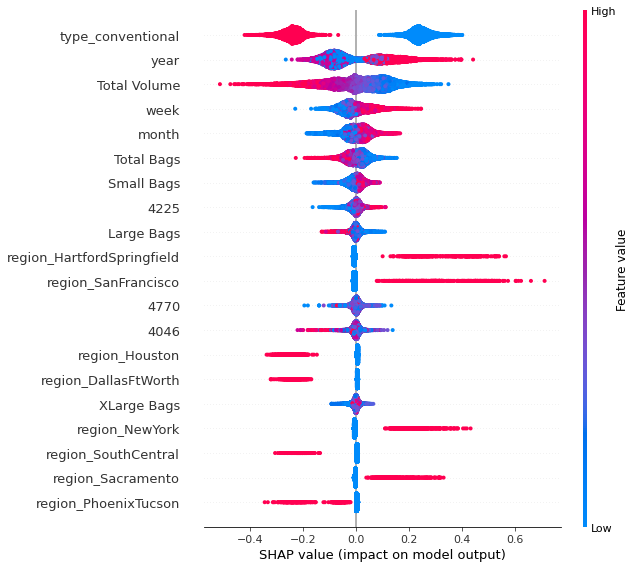

In [ ]:
shap.summary_plot(shap_values, x_test_shap)

A partir do gráfico, onde a **cor** dos pontos indica **o valor** daquela obervação de determinada **variável**, e o **eixo x o impacto desse valor** no resultado final, destaca se os seguintes pontos : 

* O tipo do abacate(`type_conventional`) está tendo um impacto muito grande, em que quando é do tipo **convencional**(pontos vermelhos) tem um **impacto negativo** no resultado, e quando é **orgânico**(pontos azuis) tem um **impacto positivo** no resultado. 

* O ano(`year`), mês(`month`) e semana(`week`) apresentam um grande impacto também indicando que a **sazonalidade é um fator importante no resultado**, confirmando o que foi visto na análise exploratória.

* O **volume total** possui uma grande importância, onde valores **mais altos**(pontos vermelhos) apresentam um **impacto negativo no preço** e valores **mais baixos**(pontos azuis) apresentam um **impacto positivo no preço**.

* Regiões como `HartfordSpringfield`, `SanFrancisco`, `NewYork` e `Sacramento` possuem um impacto positivo no preço, enquanto regiões como `Houston`, `DallasFtWorth`, `SouthCentral` e `PhoenixTucson` apresentam um impacto negativo no preço, indicando que a **região também está tendo seu papel ao predizer esses valores**.

**OBS: Nesse caso o impacto positivo se refere a um aumento do preço e o impacto negativo a uma diminuição do preço**

# Conclusões

Para finalizar o desafio vou listar as conclusões que foram possíveis estabelecer a partir tanto da análise exploratória quanto dos modelos sobre o comportamento do preço médio do abacate nos Estados Unidos em relação as demais variáveis.

* O preço do abacate possui uma **sazonalidade anual** em relação ao mês e a semana do ano.

* Abacates **orgânicos** possuem uma tendência de serem **mais caros** que abacates convencinais.

* O preço médio do abacate **difere dependendo da região correspondente**.

* O **volume total** possui uma  **relação negativa** em relação ao **preço do abacate**.

* O modelo que obteve o melhor resultado foi o **`XGBRegressor`**.

Além disso os resultados finais ao predizer o valor do preço do abacate foram:

|R2 Médio   |RMSE Médio|
|:----------|:---------|
|0.9354     |0.1023

# Agradecimentos

Gostaria de agradecer toda a equipe da [Neuron](https://medium.com/neurondsai) por todo o evento do Bootcamp Data Science na prática II, com palestras muito interessantes apresentando todo esse mundo da ciência de dados com temas super úteis e informativos, além de propor esse desafio onde pude aplicar conhecimentos que venho adquirindo a partir de um dataset que fiquei muito empolgado explorando. 


# Contato

[Linkedin](https://www.linkedin.com/in/pedrohcalmeida/)<br>

[Github](https://github.com/PedroHCAlmeida)

# Referências

https://seaborn.pydata.org/

https://lightgbm.readthedocs.io/en/latest/Python-API.html

https://xgboost.readthedocs.io/en/latest/

https://scikit-learn.org/stable/

https://matplotlib.org/

https://pandas.pydata.org/

https://shap.readthedocs.io/en/latest/index.html

https://machinelearningmastery.com/k-fold-cross-validation#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation

https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

https://towardsdatascience.com/shap-for-feature-selection-and-hyperparameter-tuning-a330ec0ea104

https://stackoverflow.com/questions/33049884/how-to-plot-2-seaborn-lmplots-side-by-side